<img style="float: left; margin: 30px 15px 15px 15px;" src="https://oci02.img.iteso.mx/Identidades-De-Instancia/ITESO/Logos%20ITESO/Logo-ITESO-Principal.jpg" width="500" height="250" /> 
    
    
# <font color='navy'> Project: Credit Default Options on Stocks

<font color='black'>

- Luis Fernando Márquez Bañuelos
- Luis Eduardo Jiménez del Muro
- Fernando López Coronado
- Diego Lozoya Morales

In [1]:
import numpy as np
from scipy.stats import norm
from collections import deque
import matplotlib.pyplot as plt

## <font color='cornflowerblue'> Part 1: Implement CRR (Cox–Ross–Rubinstein) Model for European Binary Options

<div align="center">

| Variable | Esc 1 | Esc 2 | Esc 3 | Esc 4 |
|----------|-------|-------|-------|-------|
| So       | 100   | 100   | 100   | 100   |
| K        | 50    | 150   | 50    | 150   |
| r        | 5%    | 5%    | 5%    | 5%    |
| Sigma    | 60%   | 60%   | 5%    | 5%    |
| T        | 2     | 2     | 2     | 2     |
| t        | 0     | 0     | 0     | 0     |

</div>

**Tasks** 

1. Determine number of steps $N$ so that error vs. Black–Scholes < ∣ 0.001 ∣.
2. Plot convergence for each scenario and each binary option type:
    - X-axis: 𝑁(steps)
    - Y-axis: Price difference vs. Black–Scholes
    - Deliverable: 4 charts (4 scenarios).
3. Clearly state required $N$ for convergence in each case.

In [2]:
def EuroPutBinaryTree_CRR(So, K, r, v, T, n, Q):
    """
    European Cash-or-Nothing Binary Put using vectorized binomial tree.
    
    So : Spot price
    K  : Strike
    r  : Risk-free rate
    v  : Volatility
    T  : Time to maturity
    n  : Number of steps
    Q  : Cash payoff if S_T < K
    """
    
    dt = T / n
    u = np.exp(v * np.sqrt(dt))
    d = 1 / u
    disc = np.exp(-r * dt)
    p = (np.exp(r * dt) - d) / (u - d)
    
    # Vectorized final stock prices
    j = np.arange(n + 1)
    ST = So * (u ** (n - j)) * (d ** j)
    
    # Binary put payoff: Q if ST < K, else 0
    option_values = np.where(ST < K, Q, 0.0)
    
    # Backward induction (no early exercise for European)
    for i in range(n - 1, -1, -1):
        option_values = disc * (p * option_values[:-1] + (1 - p) * option_values[1:])
    
    return option_values[0]


def EuroPutBinaryBS(So, K, r, v, T, Q):
    """
    European Cash-or-Nothing Binary Put using Black-Scholes formula.
    
    So : Spot price
    K  : Strike
    r  : Risk-free rate
    v  : Volatility
    T  : Time to maturity
    Q  : Cash payoff if S_T < K
    
    Returns: Present value of binary put option
    """
    
    d2 = (np.log(So / K) + (r - 0.5 * v**2) * T) / (v * np.sqrt(T))
        
    return Q * np.exp(-r * T) * norm.cdf(-d2)

In [3]:
# Usage
# So, K, r, v, T, n, Q
So = 100
r = 0.05
T = 2
n = 1000
Q = 100

# global variable for max_convergence
N_MAX = 20_000

# Parameter sets for different scenarios
params_1 = (So, 50, r, 0.6, T, n, Q)
params_2 = (So, 150, r, 0.6, T, n, Q)
params_3 = (So, 50, r, 0.05, T, n, Q)
params_4 = (So, 150, r, 0.05, T, n, Q)

params_1_bs = (So, 50, r, 0.6, T, Q)
params_2_bs = (So, 150, r, 0.6, T, Q)
params_3_bs = (So, 50, r, 0.05, T, Q)
params_4_bs = (So, 150, r, 0.05, T, Q)

In [4]:
def find_convergence_n(So, K, r, v, T, Q, EuroPutBinaryTree,
                       tolerance=0.001, n_start=5, n_max=N_MAX):
    """
    Encuentra el mínimo n donde el precio binomial converge al de Black-Scholes.
    Ahora usa una media móvil del error con un deque de tamaño 100.
    
    Retorna: (n, binom_price, bs_price, mean_error)
    Si no converge, retorna valores en n_max.
    """

    # Precio Black–Scholes (constante)
    bs_price = EuroPutBinaryBS(So, K, r, v, T, Q)

    n = n_start
    # FiFo list
    errors = deque(maxlen=100)
    converged = False
    result = None

    while n <= n_max:

        # Precio vía árbol binomial
        binom_price = EuroPutBinaryTree(So, K, r, v, T, n, Q)
        error = abs(binom_price - bs_price)

        # Guardar el error actual
        errors.append(error)

        # Calcular media móvil solo si ya se tienen suficientes datos
        mean_error = np.mean(errors)

        # Nueva condición de convergencia
        if mean_error <= tolerance and len(errors) == errors.maxlen:
            converged = True
            result = (n, binom_price, bs_price, mean_error)
            break

        # Pasos adaptativos (tu lógica original)
        if error > 0.1:
            n += 50
        elif error > 0.01:
            n += 10
        else:
            n += 5

    # Si no converge antes de n_max
    if not converged:
        binom_price = EuroPutBinaryTree(So, K, r, v, T, n_max, Q)
        error = abs(binom_price - bs_price)
        return n_max, binom_price, bs_price, error

    return result


# Find convergence for all scenarios
scenarios = [
    ("Scenario 1 (K=50, v=0.6)", params_1_bs),
    ("Scenario 2 (K=150, v=0.6)", params_2_bs),
    ("Scenario 3 (K=50, v=0.05)", params_3_bs),
    ("Scenario 4 (K=150, v=0.05)", params_4_bs),
]

converged_n = []

for name, params in scenarios:
    result = find_convergence_n(*params, EuroPutBinaryTree_CRR)
    if result:
        n, binom, bs, err = result
        print(f"{name}:")
        print(f"  n = {n}, Binomial = {binom:.6f}, BS = {bs:.6f}, Error = {err:.6f}\n")
        converged_n.append((n))

        if n >= N_MAX:

            price_20k = EuroPutBinaryTree_CRR(params[0], params[1], params[2], params[3], params[4], 20_000, params[5])
            price_20k_1 = EuroPutBinaryTree_CRR(params[0], params[1], params[2], params[3], params[4], 20_001, params[5])

            print(f"    At n=20,000: {price_20k:.6f}, error = {abs(price_20k - bs):.6f}")
            print(f"    At n=20,001: {price_20k_1:.6f}, error = {abs(price_20k_1 - bs):.6f}")

            if abs(price_20k - bs) > abs(price_20k_1 - bs):
                print(f"    Potental of convergence at bigger n\n")

Scenario 1 (K=50, v=0.6):
  n = 20000, Binomial = 27.702758, BS = 27.585011, Error = 0.117747

    At n=20,000: 27.702758, error = 0.117747
    At n=20,001: 27.479316, error = 0.105694
    Potental of convergence at bigger n

Scenario 2 (K=150, v=0.6):
  n = 20000, Binomial = 70.790535, BS = 70.899049, Error = 0.108514

    At n=20,000: 70.790535, error = 0.108514
    At n=20,001: 70.977972, error = 0.078923
    Potental of convergence at bigger n

Scenario 3 (K=50, v=0.05):
  n = 500, Binomial = 0.000000, BS = 0.000000, Error = 0.000000

Scenario 4 (K=150, v=0.05):
  n = 500, Binomial = 90.483315, BS = 90.483141, Error = 0.000245



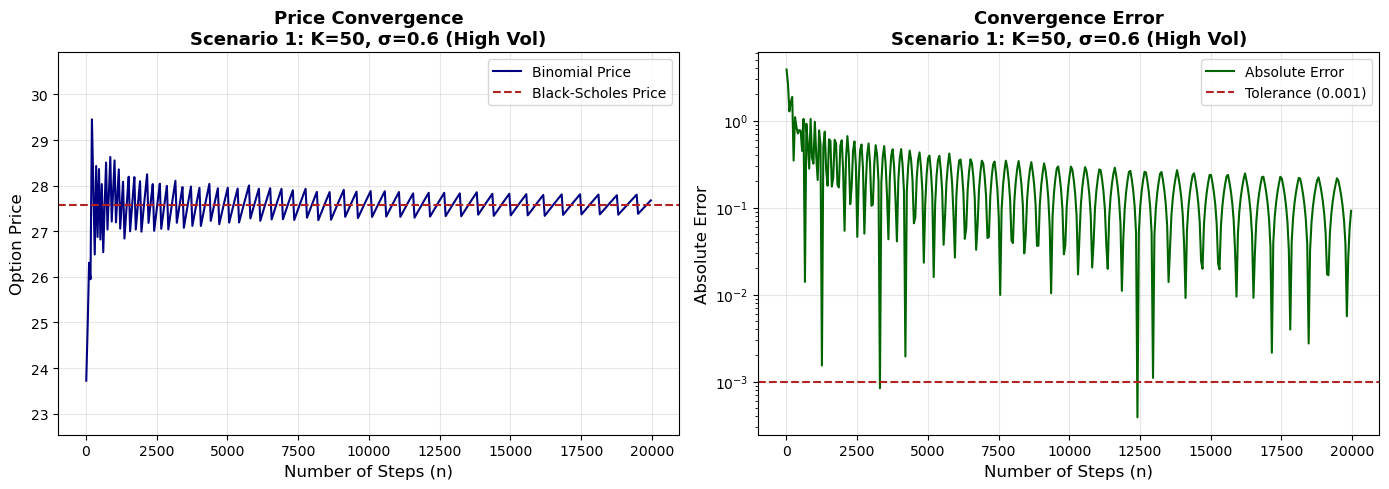

  Converged at n = 20000, Error = 0.117747



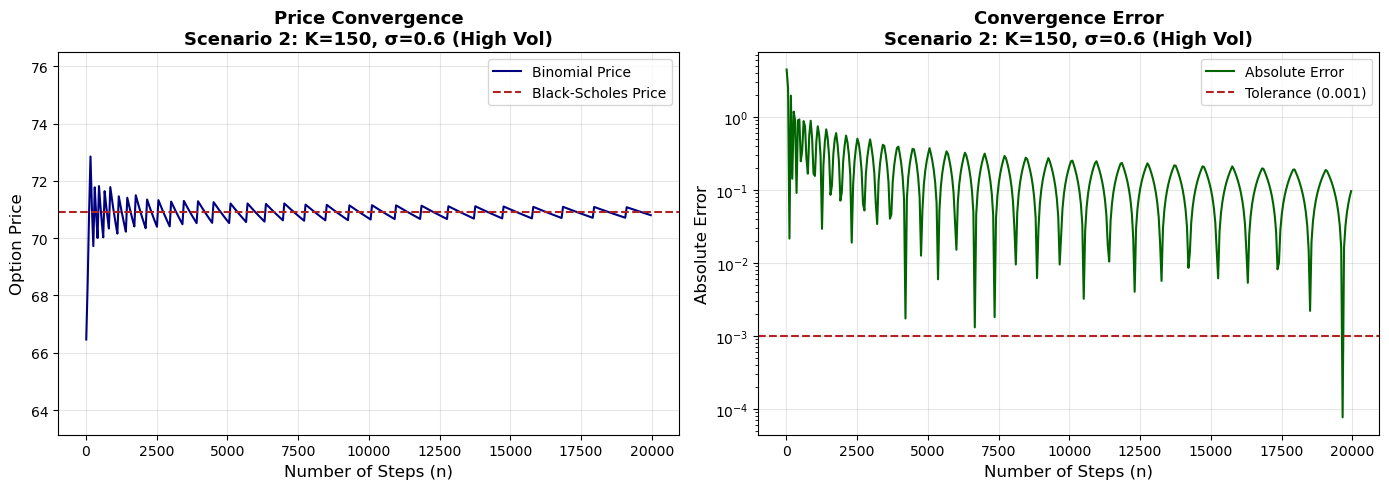

  Converged at n = 20000, Error = 0.108514



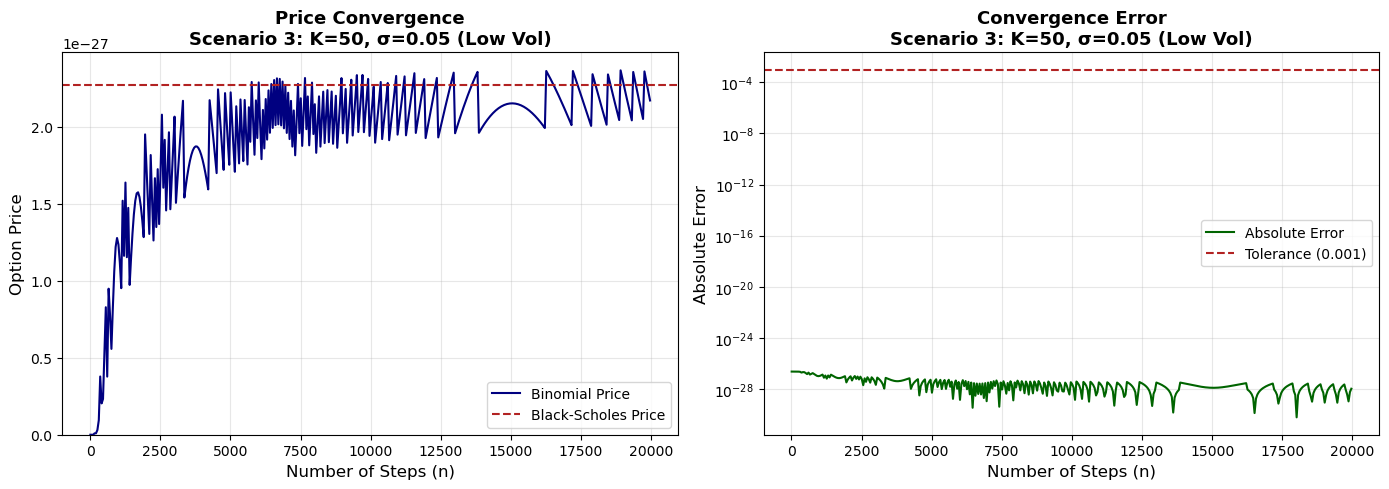

  Converged at n = 500, Error = 0.000000



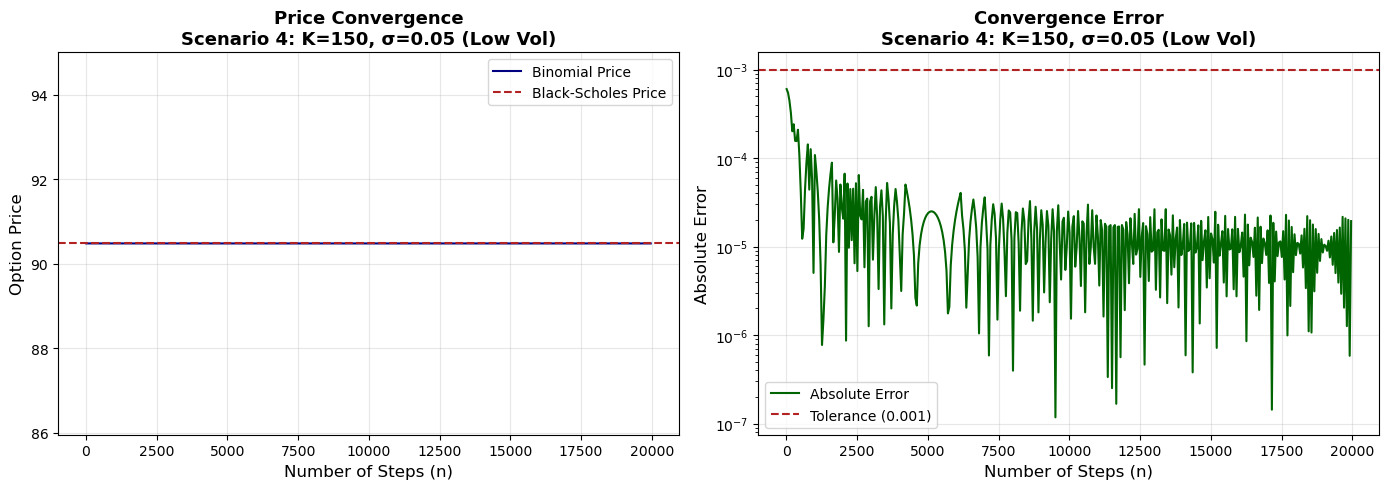

  Converged at n = 500, Error = 0.000245



In [5]:
def plot_convergence(So, K, r, v, T, Q, EuroPutBinaryTree, n_max=N_MAX, n_step=50, title=""):
    """
    Plot binomial price convergence to Black-Scholes price.
    """
    bs_price = EuroPutBinaryBS(So, K, r, v, T, Q)
    
    n_values = np.arange(10, n_max + 1, n_step)
    binom_prices = []
    errors = []
    
    for n in n_values:
        binom = EuroPutBinaryTree(So, K, r, v, T, n, Q)
        binom_prices.append(binom)
        errors.append(abs(binom - bs_price))
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Price convergence
    ax1.plot(n_values, binom_prices, color='navy', label='Binomial Price')
    ax1.axhline(y=bs_price, color='firebrick', linestyle='--', label='Black-Scholes Price')
    ax1.set_xlabel('Number of Steps (n)', fontsize=12)
    ax1.set_ylabel('Option Price', fontsize=12)
    y_min = min(binom_prices + [bs_price])*0.95
    y_max = max(binom_prices + [bs_price])*1.05
    ax1.set_ylim(y_min, y_max)
    ax1.set_title(f'Price Convergence\n{title}', fontsize=13, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Error (log scale)
    ax2.plot(n_values, errors, color='darkgreen', label='Absolute Error')
    ax2.axhline(y=0.001, color='firebrick', linestyle='--', label='Tolerance (0.001)')
    ax2.set_xlabel('Number of Steps (n)', fontsize=12)
    ax2.set_ylabel('Absolute Error', fontsize=12)
    ax2.set_title(f'Convergence Error\n{title}', fontsize=13, fontweight='bold')
    ax2.set_yscale('log')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


# Plot all scenarios
scenarios = [
    ("Scenario 1: K=50, σ=0.6 (High Vol)", params_1_bs),
    ("Scenario 2: K=150, σ=0.6 (High Vol)", params_2_bs),
    ("Scenario 3: K=50, σ=0.05 (Low Vol)", params_3_bs),
    ("Scenario 4: K=150, σ=0.05 (Low Vol)", params_4_bs),
]

for title, params in scenarios:
    fig = plot_convergence(*params, EuroPutBinaryTree_CRR, title=title)
    plt.show()
    
    # Also print convergence info
    result = find_convergence_n(*params, EuroPutBinaryTree_CRR)
    if result:
        n, binom, bs, err = result
        print(f"  Converged at n = {n}, Error = {err:.6f}\n")

## <font color='cornflowerblue'> Part 2: Implement CRR Model for American Binary Options

In [6]:
def AmericanPutBinaryTree_CRR(So, K, r, v, T, n, Q):
    """
    Vectorized and optimized American cash-or-nothing put (CRR tree).
    """

    dt = T / n
    sqrt_dt = np.sqrt(dt)

    # CRR parameters
    u = np.exp(v * sqrt_dt)
    d = 1.0 / u
    disc = np.exp(-r * dt)
    p = (np.exp(r * dt) - d) / (u - d)

    # Precompute powers of up and down moves
    # u_p[j] = u^j, d_p[j] = d^j
    u_p = u ** np.arange(n + 1)
    d_p = d ** np.arange(n + 1)

    # Terminal stock prices S_n,j = S0 u^(n-j) d^j
    j = np.arange(n + 1)
    ST = So * u_p[n - j] * d_p[j]

    # Terminal payoff (vectorized)
    option_values = np.where(ST < K, Q, 0.0)

    # Backward induction
    for i in range(n - 1, -1, -1):

        # Stock prices at step i: S[i,j] = S0 u^(i-j) d^j
        j_curr = j[:i+1]
        stock_i = So * u_p[i - j_curr] * d_p[j_curr]

        # Continuation value (vectorized)
        continuation = disc * (p * option_values[:-1] +
                               (1 - p) * option_values[1:])

        # Immediate exercise payoff
        exercise = np.where(stock_i < K, Q, 0.0)

        # American feature
        option_values = np.maximum(continuation, exercise)

    return option_values[0]

In [7]:
# Usage
# So, K, r, v, T, n, Q
So = 100
r = 0.05
T = 2
Q = 100

# Parameter sets for different scenarios
params_1 = (So, 50, r, 0.6, T, converged_n[0], Q)
params_2 = (So, 150, r, 0.6, T, converged_n[1], Q)
params_3 = (So, 50, r, 0.05, T, converged_n[2], Q)
params_4 = (So, 150, r, 0.05, T, converged_n[3], Q)

# Compute values for all scenarios
scenarios = [
    ("Scenario 1: K=50, σ=0.6 (High Vol)", params_1),
    ("Scenario 2: K=150, σ=0.6 (High Vol)", params_2),
    ("Scenario 3: K=50, σ=0.05 (Low Vol)", params_3),
    ("Scenario 4: K=150, σ=0.05 (Low Vol)", params_4)
    ]

for title, params in scenarios:
    price = AmericanPutBinaryTree_CRR(*params)
    print(f"{title}: American Binary Put Price = {price:.6f}")

Scenario 1: K=50, σ=0.6 (High Vol): American Binary Put Price = 49.540922
Scenario 2: K=150, σ=0.6 (High Vol): American Binary Put Price = 100.000000
Scenario 3: K=50, σ=0.05 (Low Vol): American Binary Put Price = 0.000000
Scenario 4: K=150, σ=0.05 (Low Vol): American Binary Put Price = 100.000000


In [8]:
def plot_AmeConvergence(So, K, r, v, T, Q, AmericanPutBinaryTree,
                        n_max=N_MAX, n_step=50, title=""):
    """
    Plot American binary put price convergence with increasing n.
    """
    n_values = np.arange(1, n_max + 1, n_step)
    binom_prices = []

    for n in n_values:
        binom_prices.append(AmericanPutBinaryTree(So, K, r, v, T, n, Q))

    plt.figure(figsize=(7, 5))
    plt.plot(n_values, binom_prices, color='navy', label='American Binary Put Price')
    plt.xlabel('Number of Steps (n)', fontsize=12)
    plt.ylabel('Option Price', fontsize=12)
    plt.title(f'American Binary Put Price Convergence\n{title}', fontsize=13, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

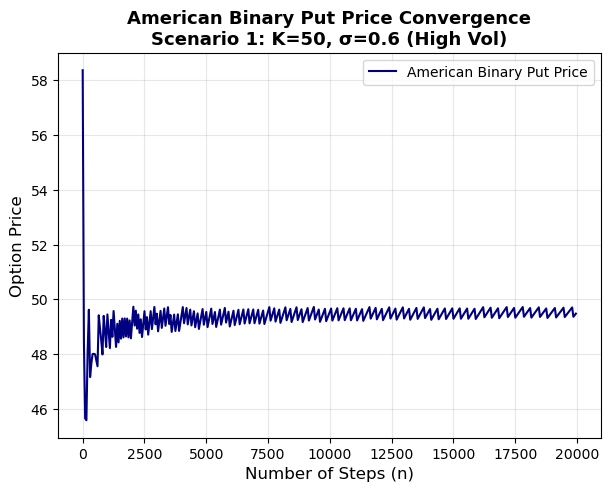

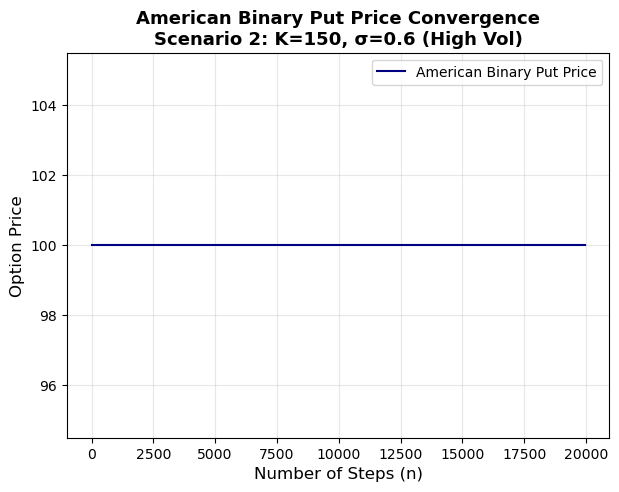

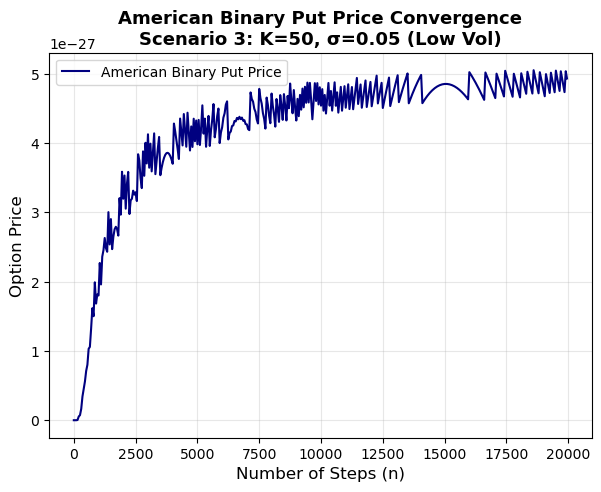

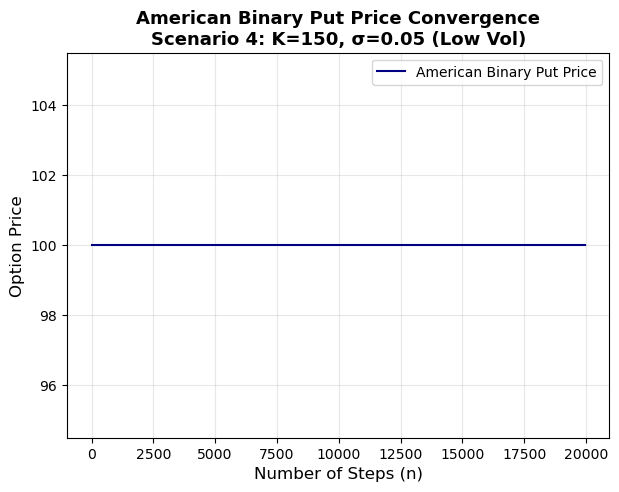

In [9]:
# Usage
# So, K, r, v, T, n, Q
So = 100
r = 0.05
T = 2
Q = 100

# Parameter sets for different scenarios
params_1 = (So, 50, r, 0.6, T, Q)
params_2 = (So, 150, r, 0.6, T, Q)
params_3 = (So, 50, r, 0.05, T, Q)
params_4 = (So, 150, r, 0.05, T, Q)

# Compute values for all scenarios
scenarios = [
    ("Scenario 1: K=50, σ=0.6 (High Vol)", params_1),
    ("Scenario 2: K=150, σ=0.6 (High Vol)", params_2),
    ("Scenario 3: K=50, σ=0.05 (Low Vol)", params_3),
    ("Scenario 4: K=150, σ=0.05 (Low Vol)", params_4)
    ]

for title, params in scenarios:
    plot_AmeConvergence(*params,
                        AmericanPutBinaryTree=AmericanPutBinaryTree_CRR,
                        title=title)

## <font color='cornflowerblue'> Part 3: Methodology Expansion

### <font color='skyblue'> Tian

#### <font color='lightblue'> European Binary Options

In [10]:
def EuroPutBinaryTree_Tian(So, K, r, v, T, n, Q):
    """
    European Cash-or-Nothing Binary Put using the Tian (1993) binomial tree.
    
    So : Spot price
    K  : Strike
    r  : Risk-free rate
    v  : Volatility
    T  : Time to maturity
    n  : Number of steps
    Q  : Cash payoff if S_T < K
    """

    dt = T / n

    # Tian parameters
    nu = np.exp(v * v * dt) # ν = e^{σ²Δt}
    edtr = np.exp(r * dt)

    # u and d from Tian's formulas
    u = 0.5 * edtr * nu * (nu + 1 + np.sqrt(nu**2 + 2*nu - 3))
    d = 0.5 * edtr * nu * (nu + 1 - np.sqrt(nu**2 + 2*nu - 3))

    # Risk-neutral probability
    p = (edtr - d) / (u - d)

    # Discount factor
    disc = np.exp(-r * dt)

    # Final stock prices
    j = np.arange(n + 1)
    ST = So * (u ** (n - j)) * (d ** j)

    # Payoff: Cash-or-nothing put
    option_values = np.where(ST < K, Q, 0.0)

    # Backward induction
    for i in range(n - 1, -1, -1):
        option_values = disc * (p * option_values[:-1] + (1 - p) * option_values[1:])

    return option_values[0]

In [11]:
# Usage
# So, K, r, v, T, n, Q
So = 100
r = 0.05
T = 2
n = 1000
Q = 100

# Parameter sets for different scenarios
params_1 = (So, 50, r, 0.6, T, n, Q)
params_2 = (So, 150, r, 0.6, T, n, Q)
params_3 = (So, 50, r, 0.05, T, n, Q)
params_4 = (So, 150, r, 0.05, T, n, Q)

params_1_bs = (So, 50, r, 0.6, T, Q)
params_2_bs = (So, 150, r, 0.6, T, Q)
params_3_bs = (So, 50, r, 0.05, T, Q)
params_4_bs = (So, 150, r, 0.05, T, Q)

# Find convergence for all scenarios
scenarios = [
    ("Scenario 1 (K=50, v=0.6)", params_1_bs),
    ("Scenario 2 (K=150, v=0.6)", params_2_bs),
    ("Scenario 3 (K=50, v=0.05)", params_3_bs),
    ("Scenario 4 (K=150, v=0.05)", params_4_bs),
]

converged_n = []

for name, params in scenarios:
    result = find_convergence_n(*params, EuroPutBinaryTree_Tian)
    if result:
        n, binom, bs, err = result
        print(f"{name}:")
        print(f"  n = {n}, Binomial = {binom:.6f}, BS = {bs:.6f}, Error = {err:.6f}\n")
        converged_n.append((n))

        if n >= N_MAX:

            price_20k = EuroPutBinaryTree_Tian(params[0], params[1], params[2], params[3], params[4], 20_000, params[5])
            price_20k_1 = EuroPutBinaryTree_Tian(params[0], params[1], params[2], params[3], params[4], 20_001, params[5])

            print(f"    At n=20,000: {price_20k:.6f}, error = {abs(price_20k - bs):.6f}")
            print(f"    At n=20,001: {price_20k_1:.6f}, error = {abs(price_20k_1 - bs):.6f}")

            if abs(price_20k - bs) > abs(price_20k_1 - bs):
                print(f"    Potental of convergence at bigger n\n")

Scenario 1 (K=50, v=0.6):
  n = 20000, Binomial = 27.403145, BS = 27.585011, Error = 0.181866

    At n=20,000: 27.403145, error = 0.181866
    At n=20,001: 27.628387, error = 0.043376
    Potental of convergence at bigger n

Scenario 2 (K=150, v=0.6):
  n = 20000, Binomial = 70.916144, BS = 70.899049, Error = 0.017094

    At n=20,000: 70.916144, error = 0.017094
    At n=20,001: 70.728372, error = 0.170678
Scenario 3 (K=50, v=0.05):
  n = 500, Binomial = 0.000000, BS = 0.000000, Error = 0.000000

Scenario 4 (K=150, v=0.05):
  n = 500, Binomial = 90.483171, BS = 90.483141, Error = 0.000151



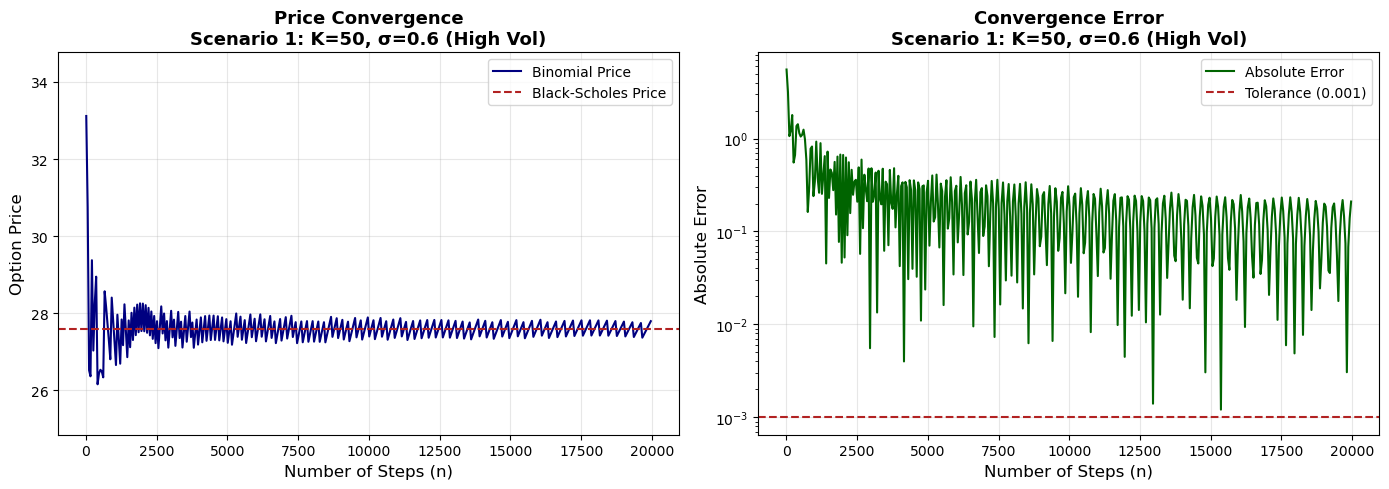

  Converged at n = 20000, Error = 0.181866



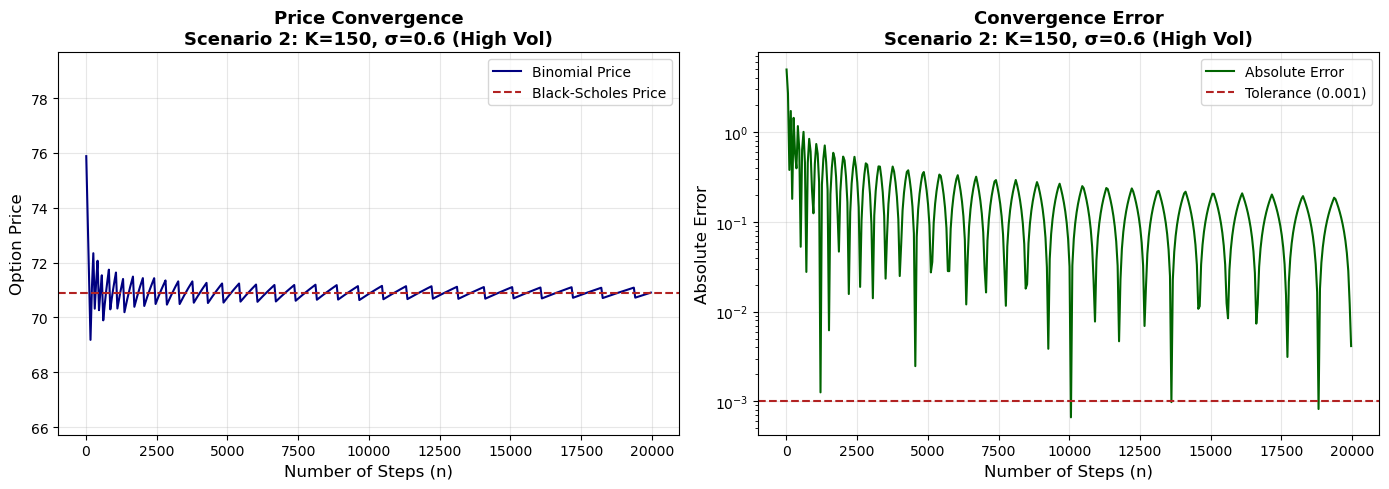

  Converged at n = 20000, Error = 0.017094



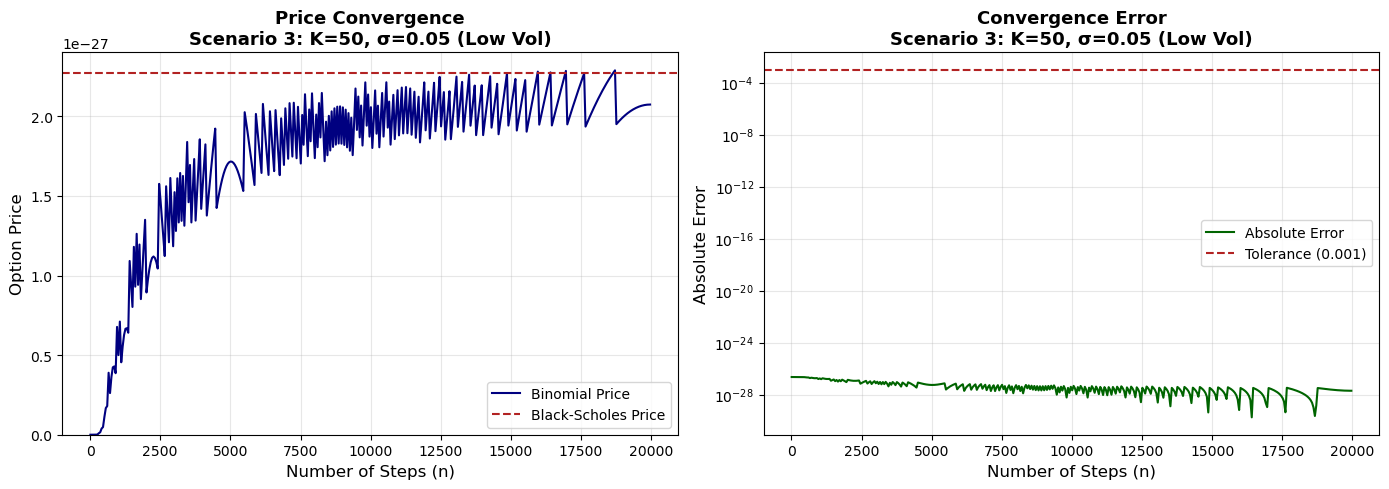

  Converged at n = 500, Error = 0.000000



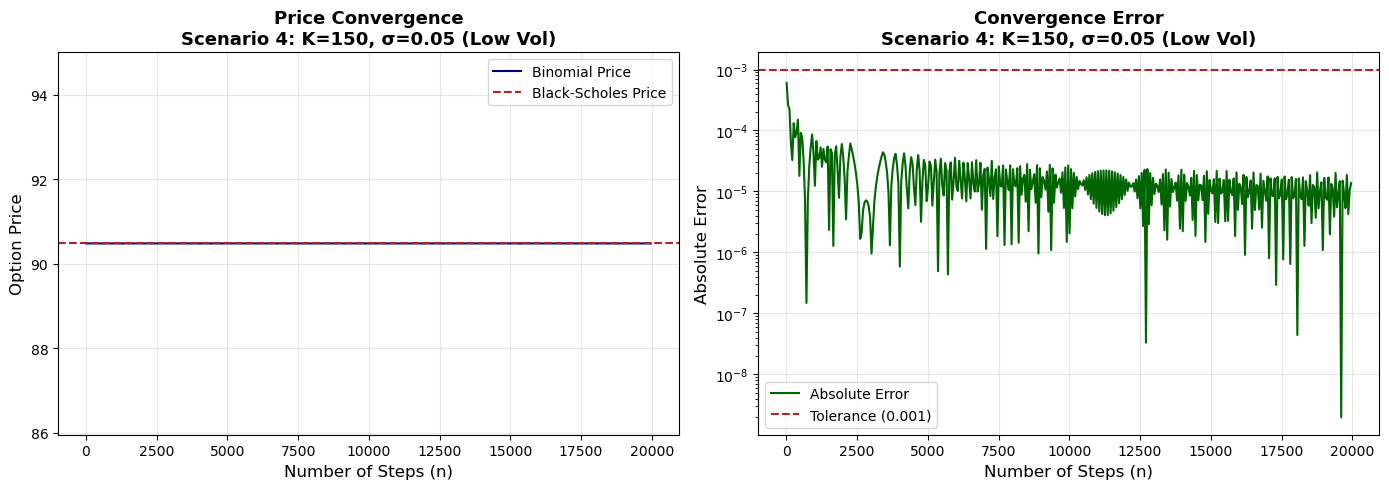

  Converged at n = 500, Error = 0.000151



In [12]:
# Plot all scenarios
scenarios = [
    ("Scenario 1: K=50, σ=0.6 (High Vol)", params_1_bs),
    ("Scenario 2: K=150, σ=0.6 (High Vol)", params_2_bs),
    ("Scenario 3: K=50, σ=0.05 (Low Vol)", params_3_bs),
    ("Scenario 4: K=150, σ=0.05 (Low Vol)", params_4_bs),
]

for title, params in scenarios:
    fig = plot_convergence(*params, EuroPutBinaryTree_Tian, title=title)
    plt.show()
    
    # Also print convergence info
    result = find_convergence_n(*params, EuroPutBinaryTree_Tian)
    if result:
        n, binom, bs, err = result
        print(f"  Converged at n = {n}, Error = {err:.6f}\n")

#### <font color='lightblue'> American Binary Options

In [13]:
def AmericanPutBinaryTree_Tian(So, K, r, v, T, n, Q):
    """
    American Cash-or-Nothing Binary Put using Tian (1993) binomial tree.
    
    So : Spot price
    K  : Strike
    r  : Risk-free rate
    v  : Volatility
    T  : Time to maturity
    n  : Number of steps
    Q  : Cash payoff if S < K
    """
    
    dt = T / n

    # Tian parameters
    nu = np.exp(v * v * dt)             # ν = e^{σ²Δt}
    edtr = np.exp(r * dt)

    u = 0.5 * edtr * nu * (nu + 1 + np.sqrt(nu**2 + 2*nu - 3))
    d = 0.5 * edtr * nu * (nu + 1 - np.sqrt(nu**2 + 2*nu - 3))
    
    p = (edtr - d) / (u - d)
    disc = np.exp(-r * dt)

    # Precompute powers for vectorized stock-price construction
    u_powers = u ** np.arange(n + 1)
    d_powers = d ** np.arange(n + 1)

    # Vectorized final stock prices at time T
    j = np.arange(n + 1)
    ST = So * u_powers[n - j] * d_powers[j]
    
    # Terminal payoff - Binary put: Q if ST < K, else 0
    option_values = np.where(ST < K, Q, 0.0)
    
    # Backward induction with early exercise
    for i in range(n - 1, -1, -1):
        # Stock prices at time step i
        j_current = j[:i+1]
        stock_current = So * u_powers[i - j_current] * d_powers[j_current]
        
        # Continuation value (expected discounted value)
        continuation = disc * (
            p * option_values[:-1] + (1 - p) * option_values[1:]
        )
        
        # Early exercise value - Binary put: Q if stock < K, else 0
        exercise_values = np.where(stock_current < K, Q, 0.0)
        
        # American feature: take maximum of continuation and exercise
        option_values = np.maximum(continuation, exercise_values)
    
    return option_values[0]

In [14]:
# Usage
# So, K, r, v, T, n, Q
So = 100
r = 0.05
T = 2
Q = 100

# Parameter sets for different scenarios
params_1 = (So, 50, r, 0.6, T, converged_n[0], Q)
params_2 = (So, 150, r, 0.6, T, converged_n[1], Q)
params_3 = (So, 50, r, 0.05, T, converged_n[2], Q)
params_4 = (So, 150, r, 0.05, T, converged_n[3], Q)

# Compute values for all scenarios
scenarios = [
    ("Scenario 1: K=50, σ=0.6 (High Vol)", params_1),
    ("Scenario 2: K=150, σ=0.6 (High Vol)", params_2),
    ("Scenario 3: K=50, σ=0.05 (Low Vol)", params_3),
    ("Scenario 4: K=150, σ=0.05 (Low Vol)", params_4)
    ]

for title, params in scenarios:
    price = AmericanPutBinaryTree_Tian(*params)
    print(f"{title}: American Binary Put Price = {price:.6f}")

Scenario 1: K=50, σ=0.6 (High Vol): American Binary Put Price = 49.536949
Scenario 2: K=150, σ=0.6 (High Vol): American Binary Put Price = 100.000000
Scenario 3: K=50, σ=0.05 (Low Vol): American Binary Put Price = 0.000000
Scenario 4: K=150, σ=0.05 (Low Vol): American Binary Put Price = 100.000000


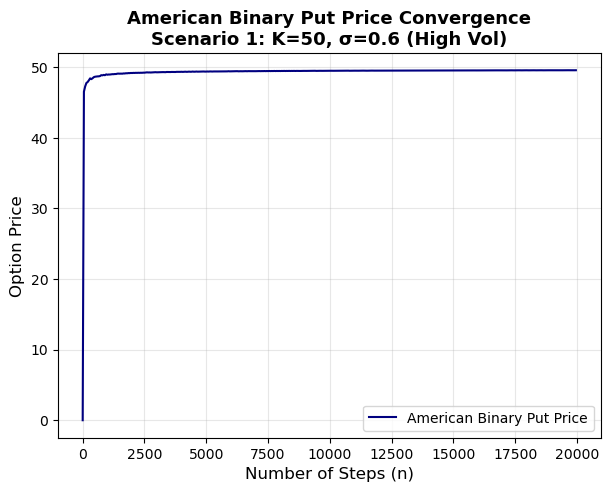

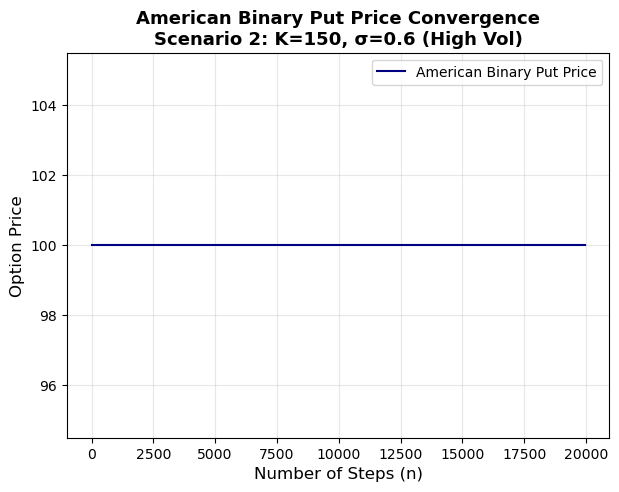

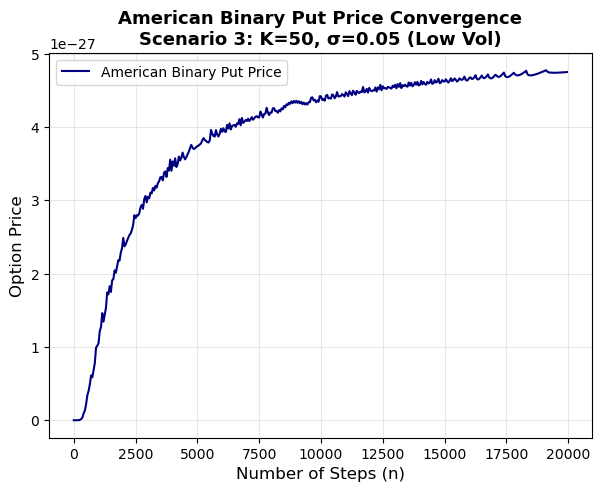

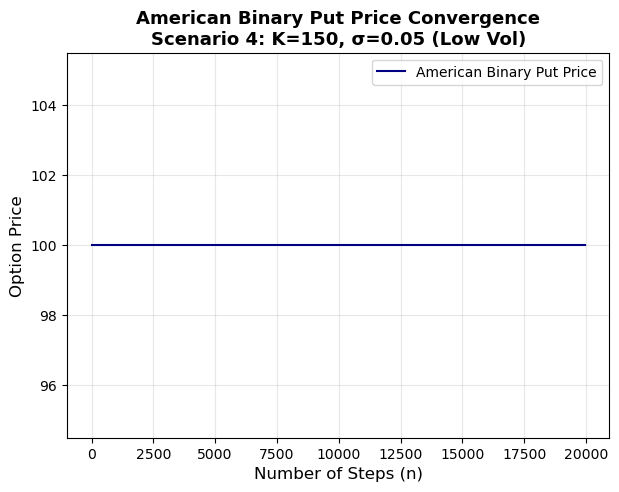

In [15]:
# Usage
# So, K, r, v, T, n, Q
So = 100
r = 0.05
T = 2
Q = 100

# Parameter sets for different scenarios
params_1 = (So, 50, r, 0.6, T, Q)
params_2 = (So, 150, r, 0.6, T, Q)
params_3 = (So, 50, r, 0.05, T, Q)
params_4 = (So, 150, r, 0.05, T, Q)

# Compute values for all scenarios
scenarios = [
    ("Scenario 1: K=50, σ=0.6 (High Vol)", params_1),
    ("Scenario 2: K=150, σ=0.6 (High Vol)", params_2),
    ("Scenario 3: K=50, σ=0.05 (Low Vol)", params_3),
    ("Scenario 4: K=150, σ=0.05 (Low Vol)", params_4)
    ]

for title, params in scenarios:
    plot_AmeConvergence(*params,
                        AmericanPutBinaryTree=AmericanPutBinaryTree_Tian,
                        title=title)

### <font color='skyblue'> Jarrow-Rudd

#### <font color='lightblue'> European Binary Options

In [16]:
def EuroPutBinaryTree_JR(So, K, r, v, T, n, Q):
    """
    European Cash-or-Nothing Binary Put using Jarrow–Rudd binomial tree.
    
    So : Spot price
    K  : Strike
    r  : Risk-free rate
    v  : Volatility (sigma)
    T  : Time to maturity
    n  : Number of steps
    Q  : Cash payoff if S_T < K
    """
    dt = T / n
    sqrt_dt = np.sqrt(dt)

    # Jarrow–Rudd parameters
    u = np.exp((r - 0.5 * v**2) * dt + v * sqrt_dt)
    d = np.exp((r - 0.5 * v**2) * dt - v * sqrt_dt)
    disc = np.exp(-r * dt)
    p = (np.exp(r * dt) - d) / (u - d)

    # Final stock prices
    j = np.arange(n + 1)
    ST = So * (u ** (n - j)) * (d ** j)

    # Terminal payoff (binary put)
    option_values = np.where(ST < K, Q, 0.0)

    # Backward induction (no early exercise)
    for i in range(n - 1, -1, -1):
        option_values = disc * (p * option_values[:-1] + (1 - p) * option_values[1:])

    return option_values[0]

In [17]:
# Usage
# So, K, r, v, T, n, Q
So = 100
r = 0.05
T = 2
n = 1000
Q = 100

# Parameter sets for different scenarios
params_1 = (So, 50, r, 0.6, T, n, Q)
params_2 = (So, 150, r, 0.6, T, n, Q)
params_3 = (So, 50, r, 0.05, T, n, Q)
params_4 = (So, 150, r, 0.05, T, n, Q)

params_1_bs = (So, 50, r, 0.6, T, Q)
params_2_bs = (So, 150, r, 0.6, T, Q)
params_3_bs = (So, 50, r, 0.05, T, Q)
params_4_bs = (So, 150, r, 0.05, T, Q)

# Find convergence for all scenarios
scenarios = [
    ("Scenario 1 (K=50, v=0.6)", params_1_bs),
    ("Scenario 2 (K=150, v=0.6)", params_2_bs),
    ("Scenario 3 (K=50, v=0.05)", params_3_bs),
    ("Scenario 4 (K=150, v=0.05)", params_4_bs),
]

converged_n = []

for name, params in scenarios:
    result = find_convergence_n(*params, EuroPutBinaryTree_JR)
    if result:
        n, binom, bs, err = result
        print(f"{name}:")
        print(f"  n = {n}, Binomial = {binom:.6f}, BS = {bs:.6f}, Error = {err:.6f}\n")
        converged_n.append((n))

        if n >= N_MAX:

            price_20k = EuroPutBinaryTree_JR(params[0], params[1], params[2], params[3], params[4], 20_000, params[5])
            price_20k_1 = EuroPutBinaryTree_JR(params[0], params[1], params[2], params[3], params[4], 20_001, params[5])

            print(f"    At n=20,000: {price_20k:.6f}, error = {abs(price_20k - bs):.6f}")
            print(f"    At n=20,001: {price_20k_1:.6f}, error = {abs(price_20k_1 - bs):.6f}")

            if abs(price_20k - bs) > abs(price_20k_1 - bs):
                print(f"    Potental of convergence at bigger n\n")

Scenario 1 (K=50, v=0.6):
  n = 20000, Binomial = 27.404018, BS = 27.585011, Error = 0.180993

    At n=20,000: 27.404018, error = 0.180993
    At n=20,001: 27.628240, error = 0.043229
    Potental of convergence at bigger n

Scenario 2 (K=150, v=0.6):
  n = 20000, Binomial = 70.915675, BS = 70.899049, Error = 0.016626

    At n=20,000: 70.915675, error = 0.016626
    At n=20,001: 70.727053, error = 0.171996
Scenario 3 (K=50, v=0.05):
  n = 500, Binomial = 0.000000, BS = 0.000000, Error = 0.000000

Scenario 4 (K=150, v=0.05):
  n = 500, Binomial = 90.483129, BS = 90.483141, Error = 0.000126



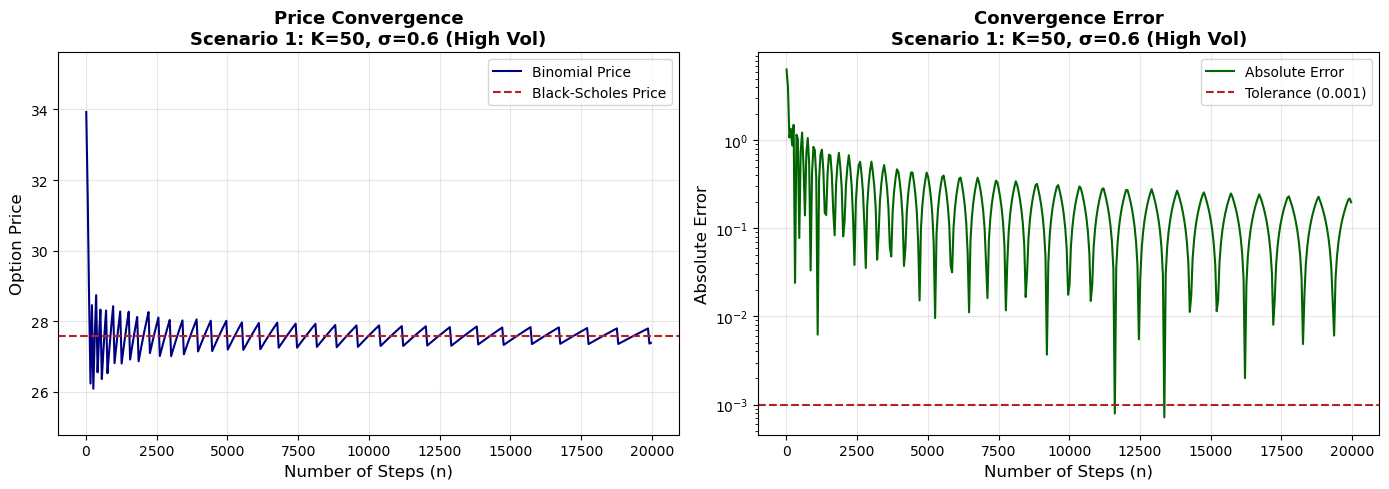

  Converged at n = 20000, Error = 0.180993



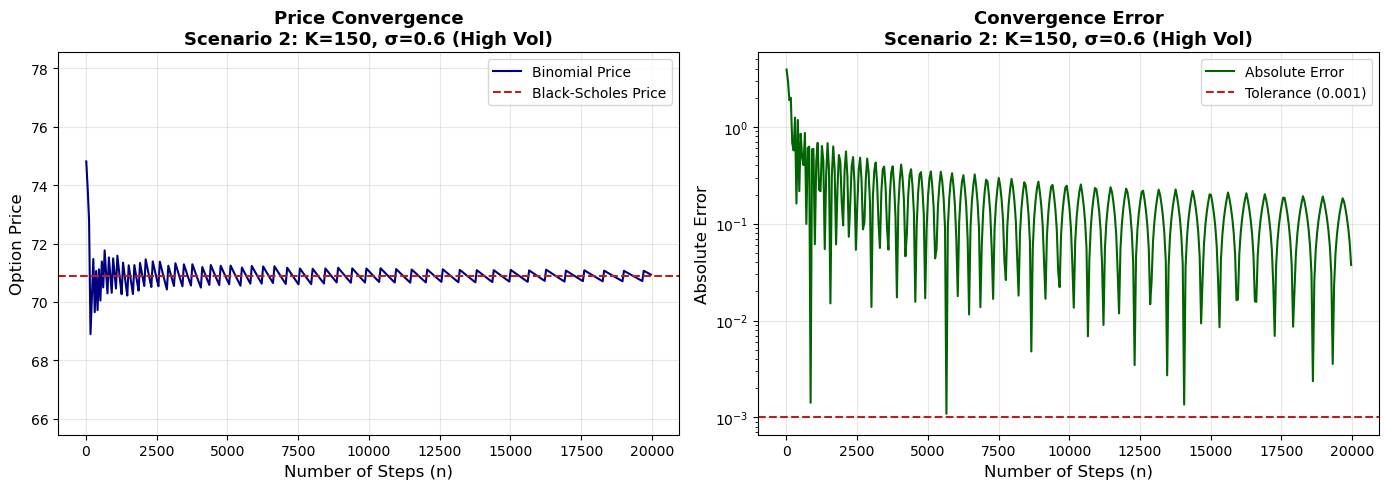

  Converged at n = 20000, Error = 0.016626



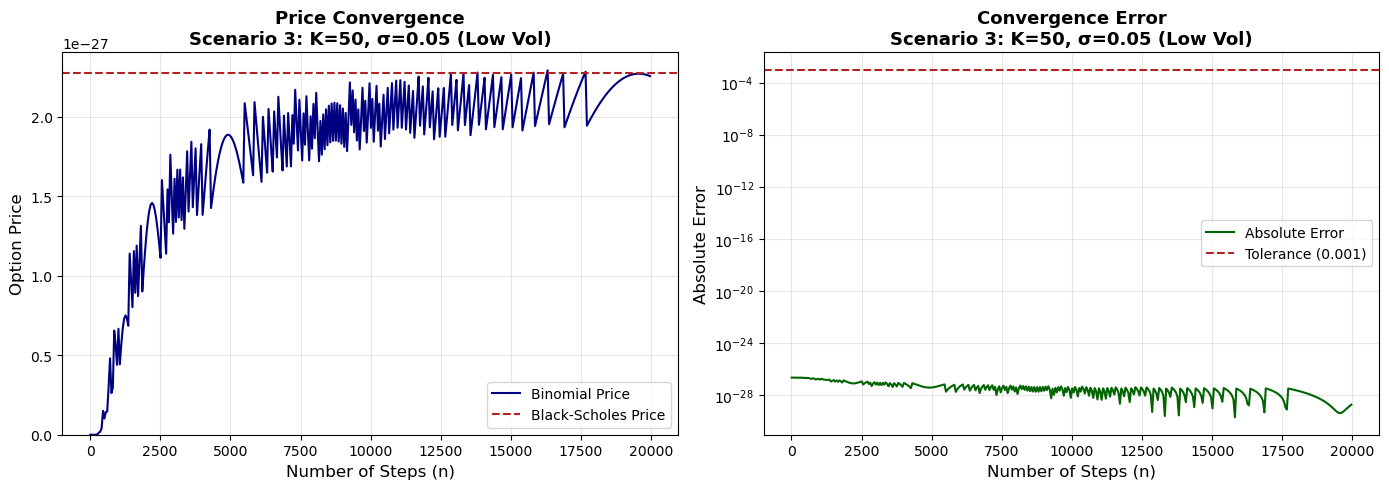

  Converged at n = 500, Error = 0.000000



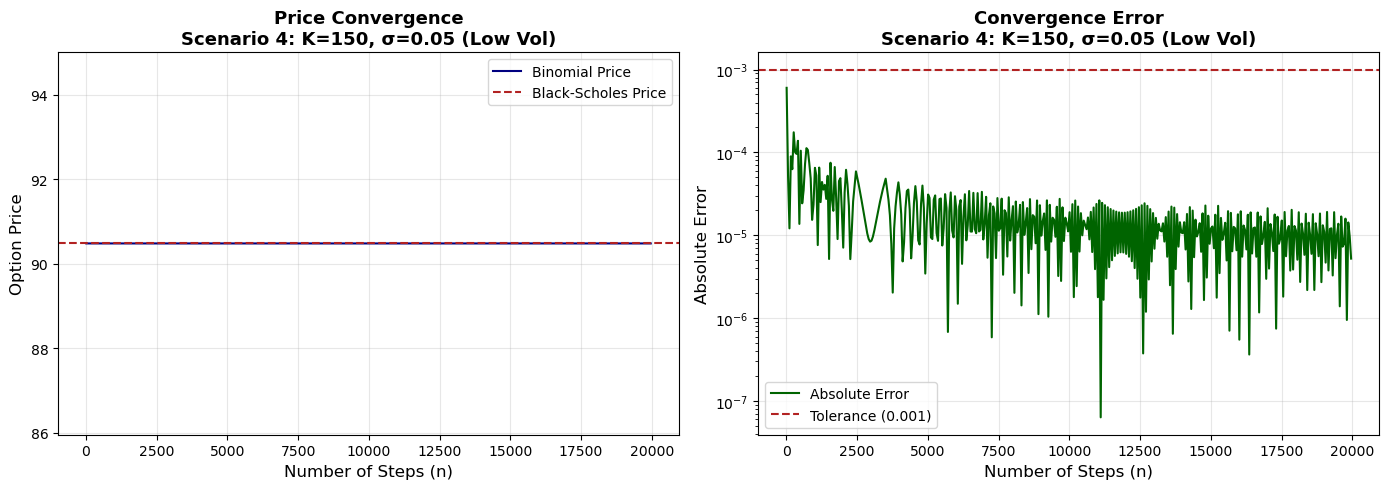

  Converged at n = 500, Error = 0.000126



In [18]:
# Plot all scenarios
scenarios = [
    ("Scenario 1: K=50, σ=0.6 (High Vol)", params_1_bs),
    ("Scenario 2: K=150, σ=0.6 (High Vol)", params_2_bs),
    ("Scenario 3: K=50, σ=0.05 (Low Vol)", params_3_bs),
    ("Scenario 4: K=150, σ=0.05 (Low Vol)", params_4_bs),
]

for title, params in scenarios:
    fig = plot_convergence(*params, EuroPutBinaryTree_JR, title=title)
    plt.show()
    
    # Also print convergence info
    result = find_convergence_n(*params, EuroPutBinaryTree_JR)
    if result:
        n, binom, bs, err = result
        print(f"  Converged at n = {n}, Error = {err:.6f}\n")

#### <font color='lightblue'> American Binary Options

In [19]:
def AmericanPutBinaryTree_JR(So, K, r, v, T, n, Q):
    """
    American Cash-or-Nothing Binary Put using Jarrow–Rudd binomial tree.
    
    So : Spot price
    K  : Strike
    r  : Risk-free rate
    v  : Volatility (sigma)
    T  : Time to maturity
    n  : Number of steps
    Q  : Cash payoff if S < K
    """
    
    dt = T / n
    sqrt_dt = np.sqrt(dt)

    # Jarrow–Rudd parameters
    drift = (r - 0.5 * v**2) * dt
    u = np.exp(drift + v * sqrt_dt)
    d = np.exp(drift - v * sqrt_dt)
    disc = np.exp(-r * dt)
    p = (np.exp(r * dt) - d) / (u - d)

    # Precompute powers for vectorized stock-price construction
    u_powers = u ** np.arange(n + 1)
    d_powers = d ** np.arange(n + 1)

    # Final stock prices at time T
    j = np.arange(n + 1)
    ST = So * u_powers[n - j] * d_powers[j]

    # Terminal payoff - Binary put: Q if ST < K, else 0
    option_values = np.where(ST < K, Q, 0.0)

    # Backward induction with early exercise
    for i in range(n - 1, -1, -1):

        # Stock prices at time step i
        j_current = j[:i+1]
        stock_current = So * u_powers[i - j_current] * d_powers[j_current]

        # Continuation value (expected discounted value)
        continuation = disc * (
            p * option_values[:-1] + (1 - p) * option_values[1:]
        )

        # Early exercise value - Binary put: Q if stock < K, else 0
        exercise_values = np.where(stock_current < K, Q, 0.0)

        # American feature: take maximum of continuation and exercise
        option_values = np.maximum(continuation, exercise_values)

    return option_values[0]

In [20]:
# Usage
# So, K, r, v, T, n, Q
So = 100
r = 0.05
T = 2
Q = 100

# Parameter sets for different scenarios
params_1 = (So, 50, r, 0.6, T, converged_n[0], Q)
params_2 = (So, 150, r, 0.6, T, converged_n[1], Q)
params_3 = (So, 50, r, 0.05, T, converged_n[2], Q)
params_4 = (So, 150, r, 0.05, T, converged_n[3], Q)

# Compute values for all scenarios
scenarios = [
    ("Scenario 1: K=50, σ=0.6 (High Vol)", params_1),
    ("Scenario 2: K=150, σ=0.6 (High Vol)", params_2),
    ("Scenario 3: K=50, σ=0.05 (Low Vol)", params_3),
    ("Scenario 4: K=150, σ=0.05 (Low Vol)", params_4)
    ]

for title, params in scenarios:
    price = AmericanPutBinaryTree_JR(*params)
    print(f"{title}: American Binary Put Price = {price:.6f}")

Scenario 1: K=50, σ=0.6 (High Vol): American Binary Put Price = 49.531521
Scenario 2: K=150, σ=0.6 (High Vol): American Binary Put Price = 100.000000
Scenario 3: K=50, σ=0.05 (Low Vol): American Binary Put Price = 0.000000
Scenario 4: K=150, σ=0.05 (Low Vol): American Binary Put Price = 100.000000


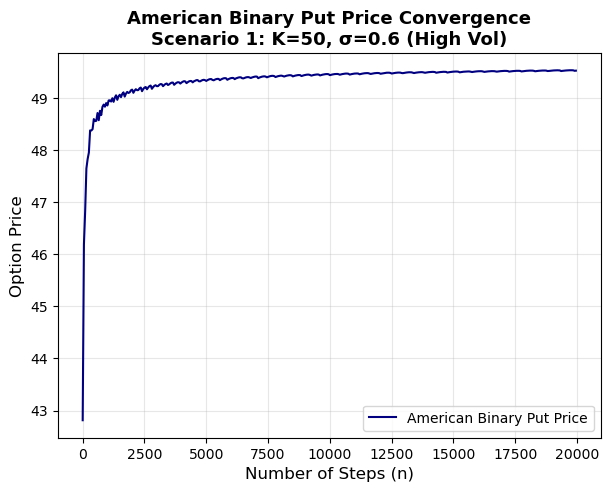

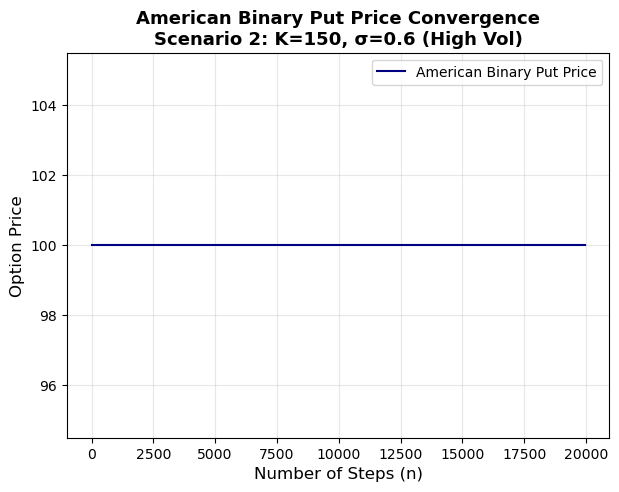

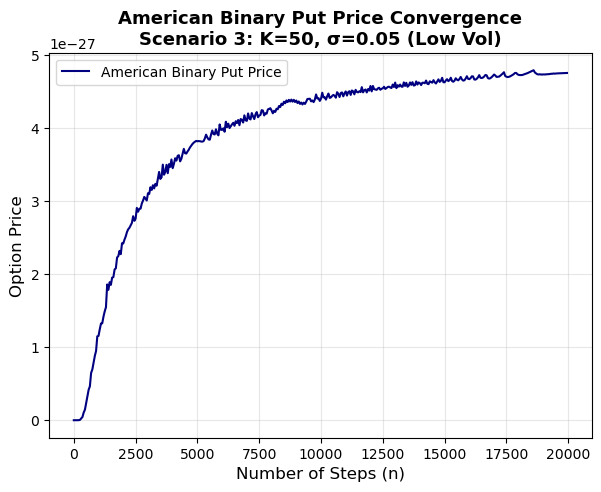

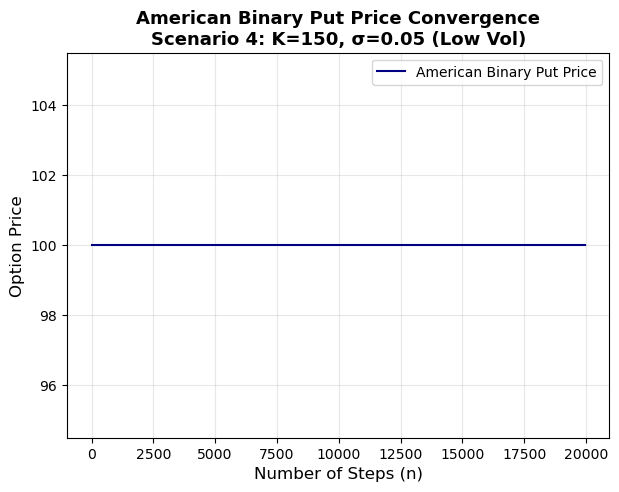

In [21]:
# Usage
# So, K, r, v, T, n, Q
So = 100
r = 0.05
T = 2
Q = 100

# Parameter sets for different scenarios
params_1 = (So, 50, r, 0.6, T, Q)
params_2 = (So, 150, r, 0.6, T, Q)
params_3 = (So, 50, r, 0.05, T, Q)
params_4 = (So, 150, r, 0.05, T, Q)

# Compute values for all scenarios
scenarios = [
    ("Scenario 1: K=50, σ=0.6 (High Vol)", params_1),
    ("Scenario 2: K=150, σ=0.6 (High Vol)", params_2),
    ("Scenario 3: K=50, σ=0.05 (Low Vol)", params_3),
    ("Scenario 4: K=150, σ=0.05 (Low Vol)", params_4)
    ]

for title, params in scenarios:
    plot_AmeConvergence(*params,
                        AmericanPutBinaryTree=AmericanPutBinaryTree_JR,
                        title=title)

### <font color='skyblue'> CRR with Drift Adjustment

#### <font color='lightblue'> European Binary Options

In [22]:
def EuroPutBinaryTree_CRR_Drift(So, K, r, v, T, n, Q):
    """
    European Cash-or-Nothing Binary Put using Cox-Ross-Rubinstein binomial tree with drift eta.

    So  : Spot price
    K   : Strike
    r   : Risk-free rate
    v   : Volatility (sigma)
    T   : Time to maturity
    n   : Number of steps
    Q   : Cash payoff if S_T < K
    """
    dt = T / n
    sqrt_dt = np.sqrt(dt)

    # Strike-centered drift
    eta = (np.log(K) - np.log(So)) / T

    # CRR with drift
    u = np.exp(eta * dt + v * sqrt_dt)
    d = np.exp(eta * dt - v * sqrt_dt)
    disc = np.exp(-r * dt)
    p = (np.exp(r * dt) - d) / (u - d)

    # Terminal stock prices
    j = np.arange(n + 1)
    ST = So * (u ** (n - j)) * (d ** j)

    # Binary put payoff
    option_values = np.where(ST < K, Q, 0.0)

    # Backward induction (European: no early exercise)
    for i in range(n - 1, -1, -1):
        option_values = disc * (p * option_values[:-1] + (1 - p) * option_values[1:])

    return option_values[0]

In [23]:
# Usage
# So, K, r, v, T, n, Q
So = 100
r = 0.05
T = 2
n = 1000
Q = 100

# Parameter sets for different scenarios
params_1 = (So, 50, r, 0.6, T, n, Q)
params_2 = (So, 150, r, 0.6, T, n, Q)
params_3 = (So, 50, r, 0.05, T, n, Q)
params_4 = (So, 150, r, 0.05, T, n, Q)

params_1_bs = (So, 50, r, 0.6, T, Q)
params_2_bs = (So, 150, r, 0.6, T, Q)
params_3_bs = (So, 50, r, 0.05, T, Q)
params_4_bs = (So, 150, r, 0.05, T, Q)

# Find convergence for all scenarios
scenarios = [
    ("Scenario 1 (K=50, v=0.6)", params_1_bs),
    ("Scenario 2 (K=150, v=0.6)", params_2_bs),
    ("Scenario 3 (K=50, v=0.05)", params_3_bs),
    ("Scenario 4 (K=150, v=0.05)", params_4_bs),
]

converged_n = []

for name, params in scenarios:
    result = find_convergence_n(*params, EuroPutBinaryTree_CRR_Drift)
    if result:
        n, binom, bs, err = result
        print(f"{name}:")
        print(f"  n = {n}, Binomial = {binom:.6f}, BS = {bs:.6f}, Error = {err:.6f}\n")
        converged_n.append((n))

        if n >= N_MAX:

            price_20k = EuroPutBinaryTree_CRR_Drift(params[0], params[1], params[2], params[3], params[4], 20_000, params[5])
            price_20k_1 = EuroPutBinaryTree_CRR_Drift(params[0], params[1], params[2], params[3], params[4], 20_001, params[5])

            print(f"    At n=20,000: {price_20k:.6f}, error = {abs(price_20k - bs):.6f}")
            print(f"    At n=20,001: {price_20k_1:.6f}, error = {abs(price_20k_1 - bs):.6f}")

            if abs(price_20k - bs) > abs(price_20k_1 - bs):
                print(f"    Potental of convergence at bigger n\n")

Scenario 1 (K=50, v=0.6):
  n = 20000, Binomial = 27.808775, BS = 27.585011, Error = 0.223764

    At n=20,000: 27.808775, error = 0.223764
    At n=20,001: 27.584306, error = 0.000705
    Potental of convergence at bigger n

Scenario 2 (K=150, v=0.6):
  n = 20000, Binomial = 71.086458, BS = 70.899049, Error = 0.187409

    At n=20,000: 71.086458, error = 0.187409
    At n=20,001: 70.899306, error = 0.000256
    Potental of convergence at bigger n

Scenario 3 (K=50, v=0.05):
  n = 600, Binomial = 0.000000, BS = 0.000000, Error = 0.000000

Scenario 4 (K=150, v=0.05):
  n = 550, Binomial = 90.483329, BS = 90.483141, Error = 0.000210



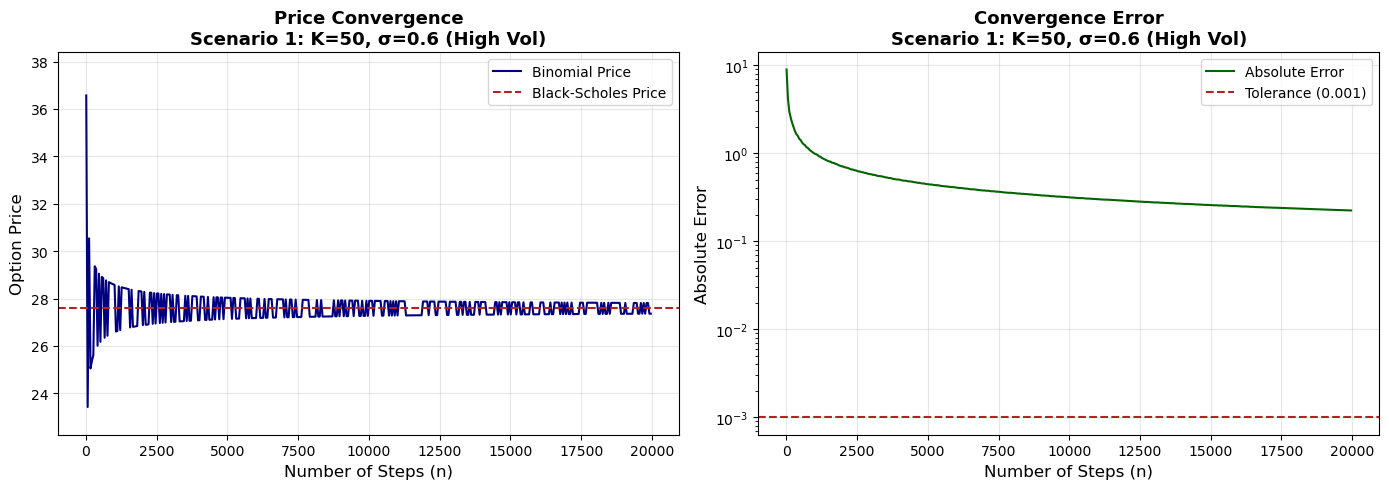

  Converged at n = 20000, Error = 0.223764



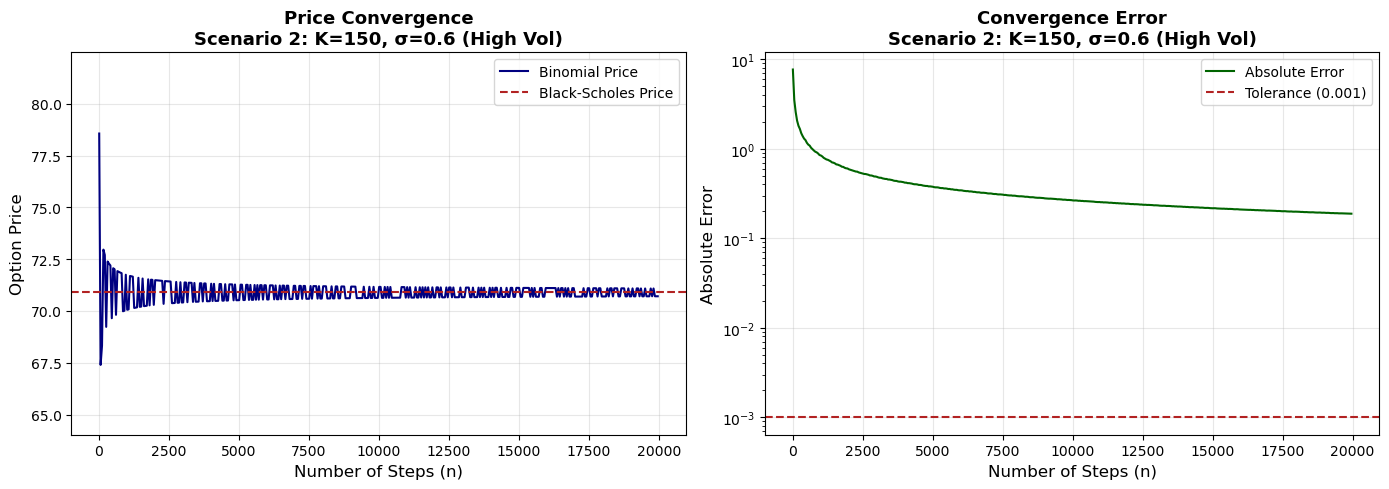

  Converged at n = 20000, Error = 0.187409



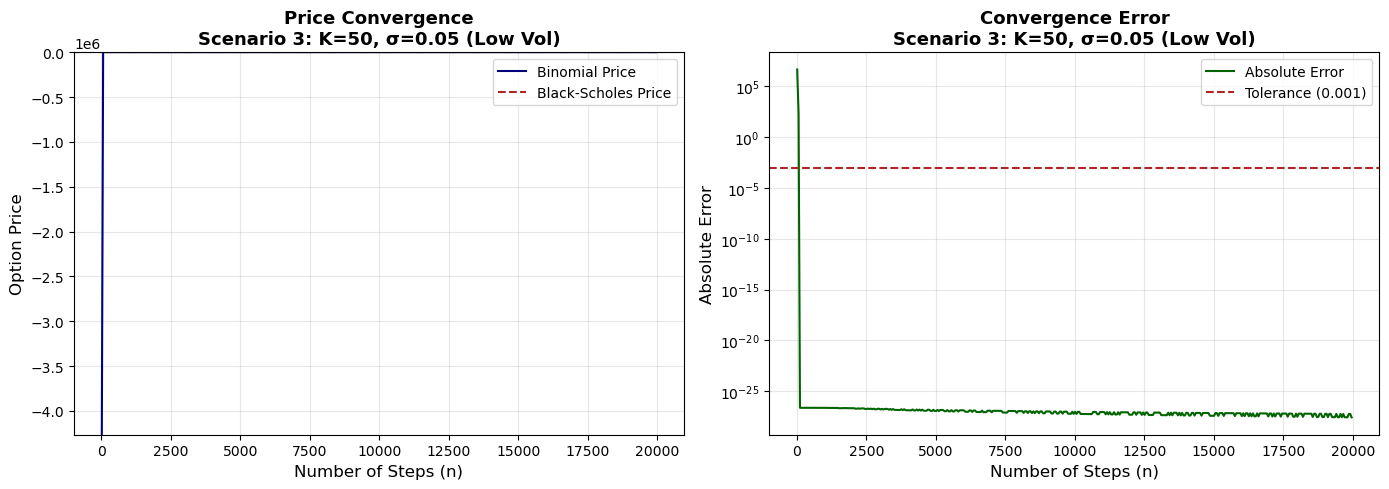

  Converged at n = 600, Error = 0.000000



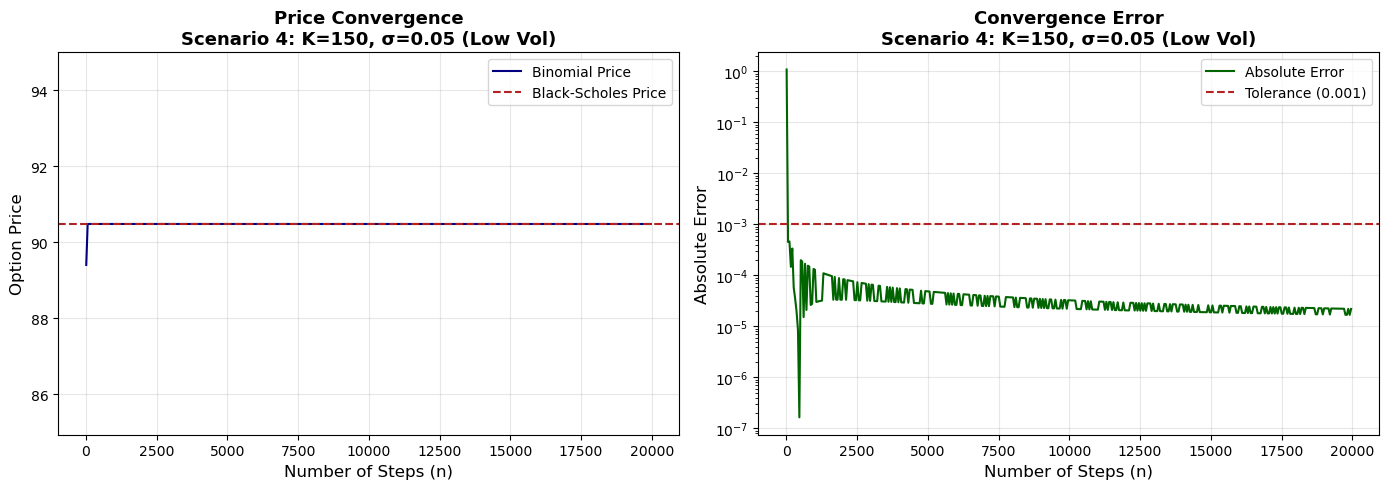

  Converged at n = 550, Error = 0.000210



In [24]:
# Plot all scenarios
scenarios = [
    ("Scenario 1: K=50, σ=0.6 (High Vol)", params_1_bs),
    ("Scenario 2: K=150, σ=0.6 (High Vol)", params_2_bs),
    ("Scenario 3: K=50, σ=0.05 (Low Vol)", params_3_bs),
    ("Scenario 4: K=150, σ=0.05 (Low Vol)", params_4_bs),
]

for title, params in scenarios:
    fig = plot_convergence(*params, EuroPutBinaryTree_CRR_Drift, title=title)
    plt.show()
    
    # Also print convergence info
    result = find_convergence_n(*params, EuroPutBinaryTree_CRR_Drift)
    if result:
        n, binom, bs, err = result
        print(f"  Converged at n = {n}, Error = {err:.6f}\n")

#### <font color='lightblue'> American Binary Options

In [25]:
def AmericanPutBinaryTree_CRR_Drift(So, K, r, v, T, n, Q):
    """
    American Cash-or-Nothing Binary Put using CRR with strike-symmetric drift.
    """
    
    dt = T / n
    sqrt_dt = np.sqrt(dt)

    # Strike-centered drift
    eta = (np.log(K) - np.log(So)) / T

    # CRR with drift
    u = np.exp(eta * dt + v * sqrt_dt)
    d = np.exp(eta * dt - v * sqrt_dt)
    disc = np.exp(-r * dt)
    p = (np.exp(r * dt) - d) / (u - d)

    # Precompute powers for vectorized stock-price construction
    u_powers = u ** np.arange(n + 1)
    d_powers = d ** np.arange(n + 1)

    # Terminal stock prices at time T
    j = np.arange(n + 1)
    ST = So * u_powers[n - j] * d_powers[j]

    # Terminal payoff - Binary put: Q if ST < K, else 0
    option_values = np.where(ST < K, Q, 0.0)

    # Backward induction with early exercise
    for i in range(n - 1, -1, -1):

        # Stock prices at step i
        j_current = j[:i+1]
        stock_current = So * u_powers[i - j_current] * d_powers[j_current]

        # Continuation value (expected discounted value)
        continuation = disc * (
            p * option_values[:-1] + (1 - p) * option_values[1:]
        )

        # Early exercise value - Binary put: Q if stock < K, else 0
        exercise = np.where(stock_current < K, Q, 0.0)

        # American feature: take maximum of continuation and exercise
        option_values = np.maximum(continuation, exercise)

    return option_values[0]

In [26]:
# Usage
# So, K, r, v, T, n, Q
So = 100
r = 0.05
T = 2
Q = 100

# Parameter sets for different scenarios
params_1 = (So, 50, r, 0.6, T, converged_n[0], Q)
params_2 = (So, 150, r, 0.6, T, converged_n[1], Q)
params_3 = (So, 50, r, 0.05, T, converged_n[2], Q)
params_4 = (So, 150, r, 0.05, T, converged_n[3], Q)

# Compute values for all scenarios
scenarios = [
    ("Scenario 1: K=50, σ=0.6 (High Vol)", params_1),
    ("Scenario 2: K=150, σ=0.6 (High Vol)", params_2),
    ("Scenario 3: K=50, σ=0.05 (Low Vol)", params_3),
    ("Scenario 4: K=150, σ=0.05 (Low Vol)", params_4)
    ]

for title, params in scenarios:
    price = AmericanPutBinaryTree_CRR_Drift(*params)
    print(f"{title}: American Binary Put Price = {price:.6f}")

Scenario 1: K=50, σ=0.6 (High Vol): American Binary Put Price = 49.536583
Scenario 2: K=150, σ=0.6 (High Vol): American Binary Put Price = 100.000000
Scenario 3: K=50, σ=0.05 (Low Vol): American Binary Put Price = 0.000000
Scenario 4: K=150, σ=0.05 (Low Vol): American Binary Put Price = 100.000000


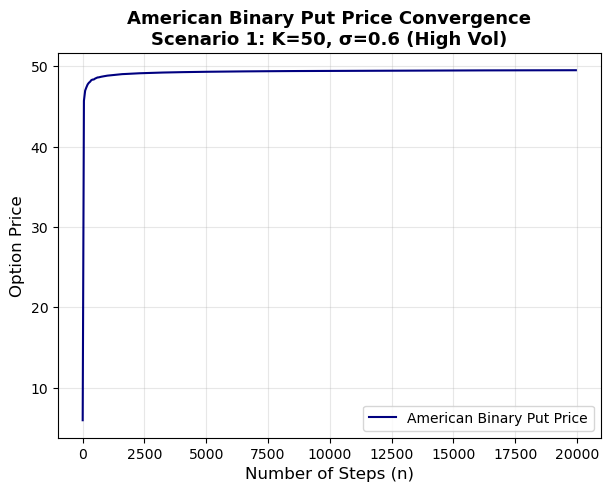

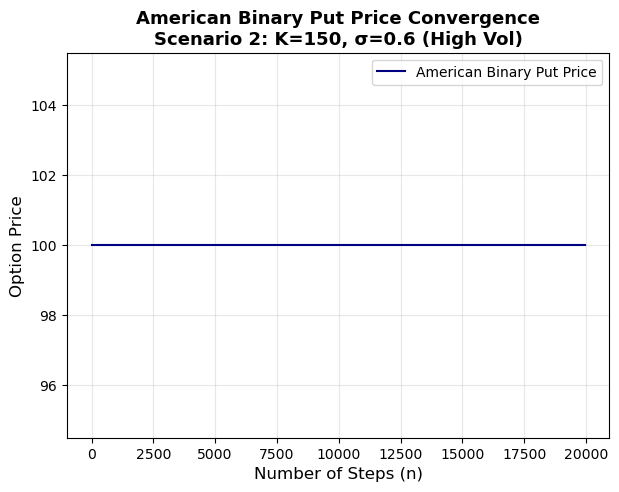

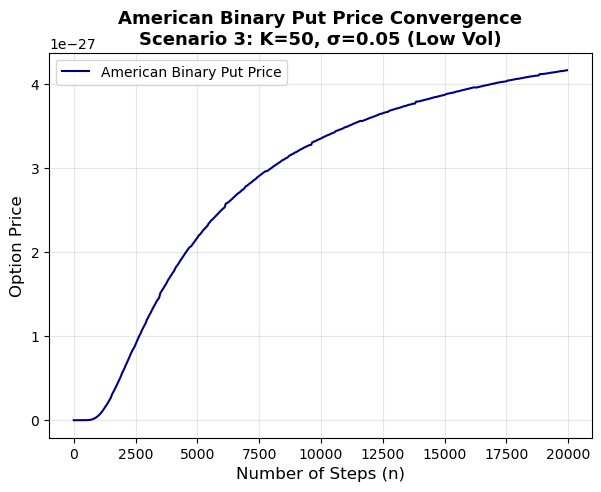

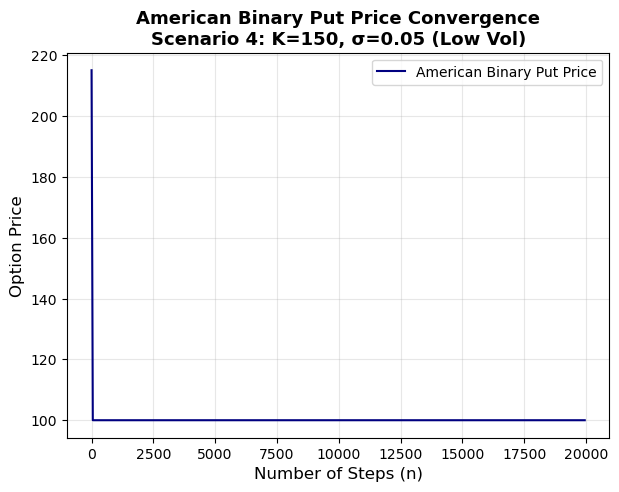

In [27]:
# Usage
# So, K, r, v, T, n, Q
So = 100
r = 0.05
T = 2
Q = 100

# Parameter sets for different scenarios
params_1 = (So, 50, r, 0.6, T, Q)
params_2 = (So, 150, r, 0.6, T, Q)
params_3 = (So, 50, r, 0.05, T, Q)
params_4 = (So, 150, r, 0.05, T, Q)

# Compute values for all scenarios
scenarios = [
    ("Scenario 1: K=50, σ=0.6 (High Vol)", params_1),
    ("Scenario 2: K=150, σ=0.6 (High Vol)", params_2),
    ("Scenario 3: K=50, σ=0.05 (Low Vol)", params_3),
    ("Scenario 4: K=150, σ=0.05 (Low Vol)", params_4)
    ]

for title, params in scenarios:
    plot_AmeConvergence(*params,
                        AmericanPutBinaryTree=AmericanPutBinaryTree_CRR_Drift,
                        title=title)

### <font color='skyblue'> Leisen-Reimer

#### <font color='lightblue'> European Binary Options

In [28]:
def h_inverse_LR(z, n):
    """
    Peizer–Pratt inversion h^{-1}(z) used in the Leisen–Reimer tree.
    n : number of steps in the binomial tree
    """
    m = n + 1/3 + 0.1/(n + 1)
    a = (z / m)**2 * (n + 1/6)
    return 0.5 + np.sign(z) * np.sqrt(0.25 - 0.25 * np.exp(-a))


def EuroPutBinaryTree_LR(So, K, r, v, T, n, Q):
    """
    European Cash-or-Nothing Binary Put using the Leisen–Reimer binomial model.

    So : Spot price
    K  : Strike
    r  : Risk-free rate
    v  : Volatility (sigma)
    T  : Time to maturity
    n  : Number of steps (ideally odd for LR)
    Q  : Cash payoff if S_T < K
    """
    dt = T / n
    sqrt_T = np.sqrt(T)

    # Black–Scholes d1, d2 (no dividends)
    d1 = (np.log(So / K) + (r + 0.5 * v**2) * T) / (v * sqrt_T)
    d2 = d1 - v * sqrt_T

    # Leisen–Reimer probabilities via Peizer–Pratt inversion
    p  = h_inverse_LR(d2, n)   # risk-neutral up probability
    p_bar = h_inverse_LR(d1, n)

    # Up and down factors
    erdt = np.exp(r * dt)
    u = erdt * p_bar / p
    d = (erdt - p * u) / (1 - p)

    disc = np.exp(-r * dt)

    # Terminal stock prices
    j = np.arange(n + 1)
    ST = So * (u ** (n - j)) * (d ** j)

    # Binary put payoff at maturity
    option_values = np.where(ST < K, Q, 0.0)

    # Backward induction (European: no early exercise)
    for i in range(n - 1, -1, -1):
        option_values = disc * (p * option_values[:-1] + (1 - p) * option_values[1:])

    return option_values[0]

In [29]:
# Usage
# So, K, r, v, T, n, Q
So = 100
r = 0.05
T = 2
n = 1000
Q = 100

# Parameter sets for different scenarios
params_1 = (So, 50, r, 0.6, T, n, Q)
params_2 = (So, 150, r, 0.6, T, n, Q)
params_3 = (So, 50, r, 0.05, T, n, Q)
params_4 = (So, 150, r, 0.05, T, n, Q)

params_1_bs = (So, 50, r, 0.6, T, Q)
params_2_bs = (So, 150, r, 0.6, T, Q)
params_3_bs = (So, 50, r, 0.05, T, Q)
params_4_bs = (So, 150, r, 0.05, T, Q)

# Find convergence for all scenarios
scenarios = [
    ("Scenario 1 (K=50, v=0.6)", params_1_bs),
    ("Scenario 2 (K=150, v=0.6)", params_2_bs),
    ("Scenario 3 (K=50, v=0.05)", params_3_bs),
    ("Scenario 4 (K=150, v=0.05)", params_4_bs),
]

converged_n = []

for name, params in scenarios:
    result = find_convergence_n(*params, EuroPutBinaryTree_LR)
    if result:
        n, binom, bs, err = result
        print(f"{name}:")
        print(f"  n = {n}, Binomial = {binom:.6f}, BS = {bs:.6f}, Error = {err:.6f}\n")
        converged_n.append((n))

        if n >= N_MAX:

            price_20k = EuroPutBinaryTree_LR(params[0], params[1], params[2], params[3], params[4], 20_000, params[5])
            price_20k_1 = EuroPutBinaryTree_LR(params[0], params[1], params[2], params[3], params[4], 20_001, params[5])

            print(f"    At n=20,000: {price_20k:.6f}, error = {abs(price_20k - bs):.6f}")
            print(f"    At n=20,001: {price_20k_1:.6f}, error = {abs(price_20k_1 - bs):.6f}")

            if abs(price_20k - bs) > abs(price_20k_1 - bs):
                print(f"    Potental of convergence at bigger n\n")

Scenario 1 (K=50, v=0.6):
  n = 20000, Binomial = 27.361348, BS = 27.585011, Error = 0.223663

    At n=20,000: 27.361348, error = 0.223663
    At n=20,001: 27.585011, error = 0.000000
    Potental of convergence at bigger n

Scenario 2 (K=150, v=0.6):
  n = 20000, Binomial = 71.086203, BS = 70.899049, Error = 0.187154

    At n=20,000: 71.086203, error = 0.187154
    At n=20,001: 70.899049, error = 0.000000
    Potental of convergence at bigger n

Scenario 3 (K=50, v=0.05):
  n = 500, Binomial = 0.000000, BS = 0.000000, Error = 0.000000

Scenario 4 (K=150, v=0.05):
  n = 500, Binomial = 90.483252, BS = 90.483141, Error = 0.000091



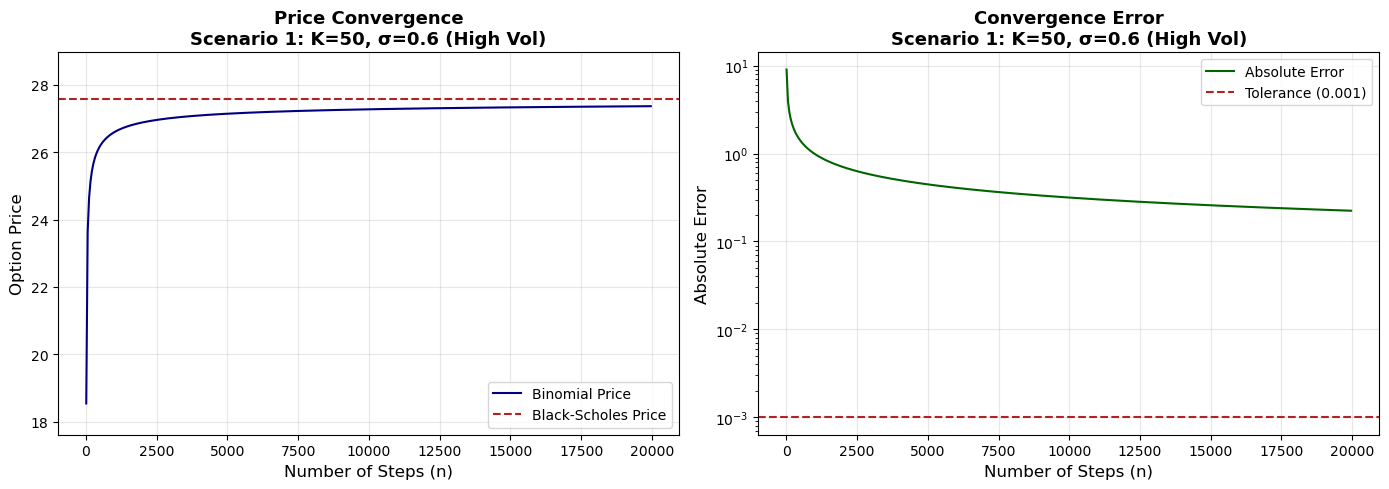

  Converged at n = 20000, Error = 0.223663



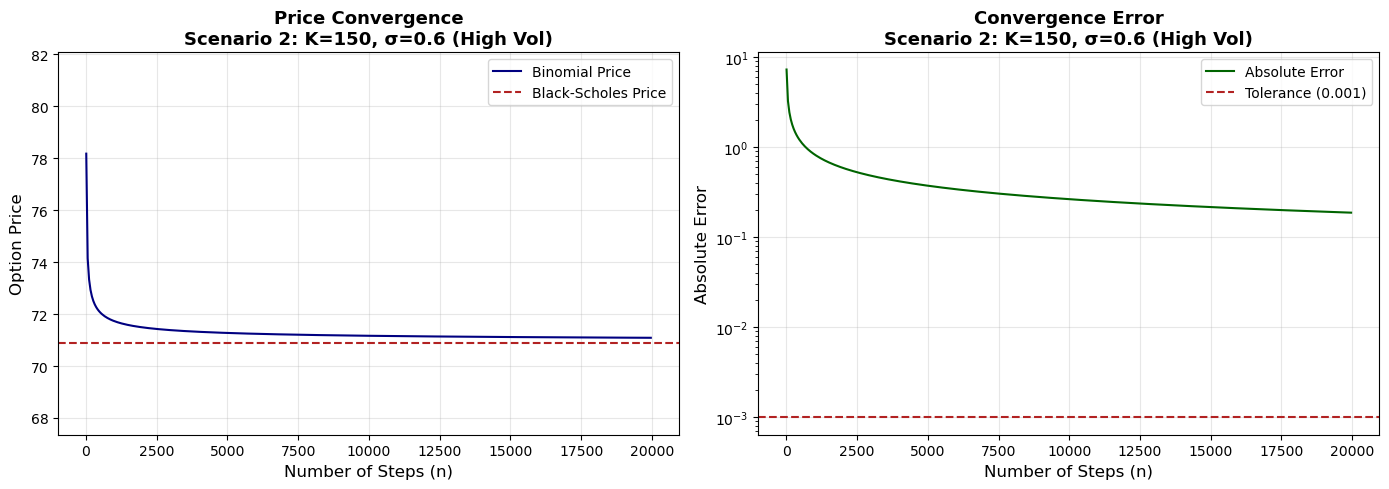

  Converged at n = 20000, Error = 0.187154



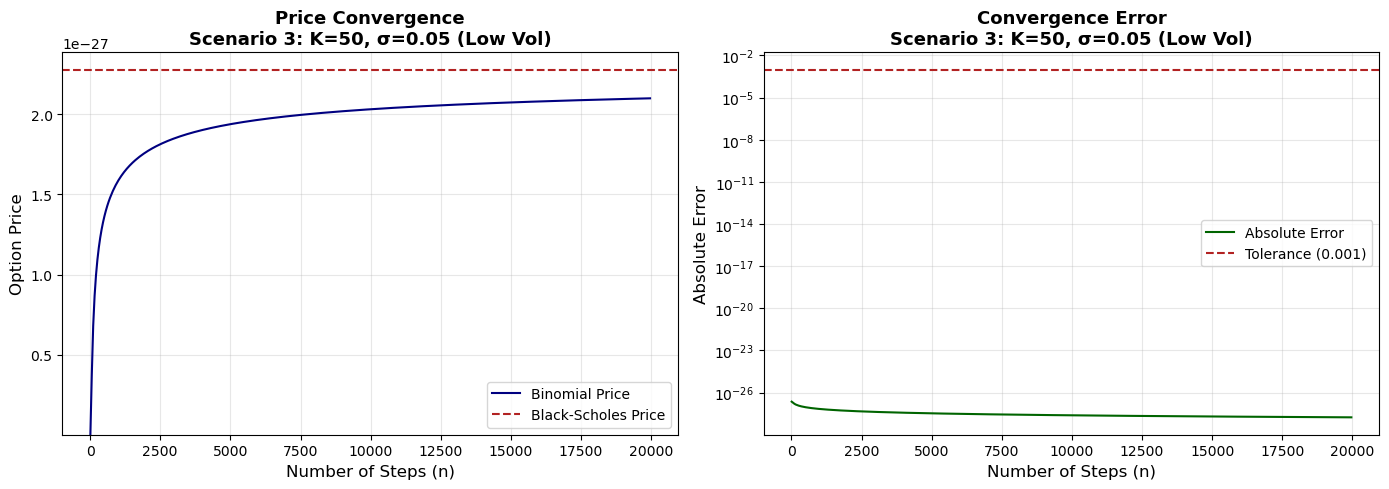

  Converged at n = 500, Error = 0.000000



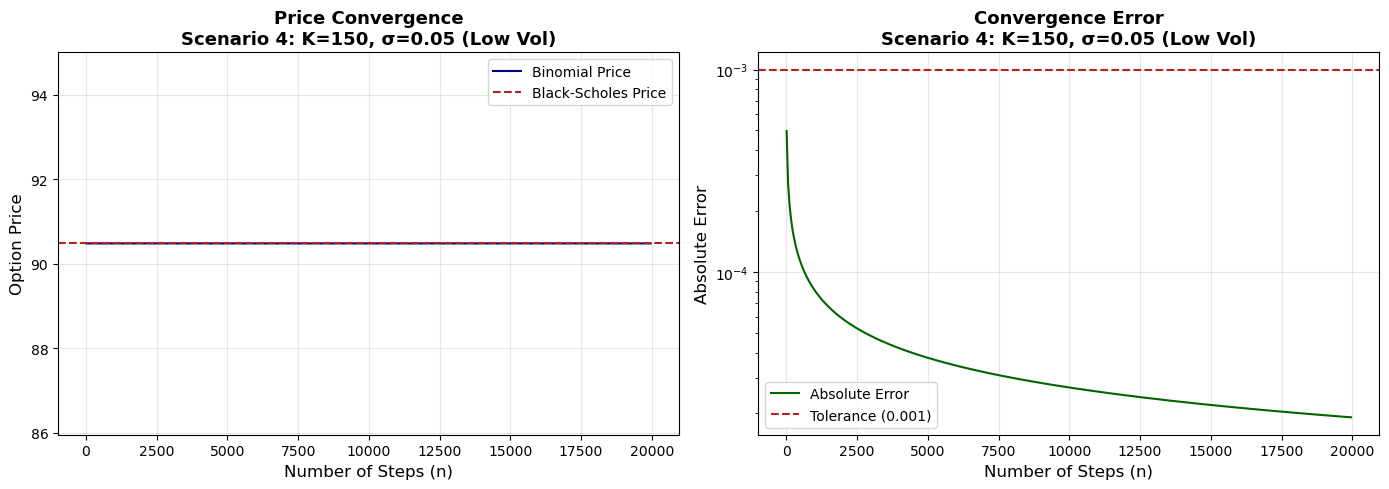

  Converged at n = 500, Error = 0.000091



In [30]:
# Plot all scenarios
scenarios = [
    ("Scenario 1: K=50, σ=0.6 (High Vol)", params_1_bs),
    ("Scenario 2: K=150, σ=0.6 (High Vol)", params_2_bs),
    ("Scenario 3: K=50, σ=0.05 (Low Vol)", params_3_bs),
    ("Scenario 4: K=150, σ=0.05 (Low Vol)", params_4_bs),
]

for title, params in scenarios:
    fig = plot_convergence(*params, EuroPutBinaryTree_LR, title=title)
    plt.show()
    
    # Also print convergence info
    result = find_convergence_n(*params, EuroPutBinaryTree_LR)
    if result:
        n, binom, bs, err = result
        print(f"  Converged at n = {n}, Error = {err:.6f}\n")

#### <font color='lightblue'> American Binary Options

In [31]:
def AmericanPutBinaryTree_LR(So, K, r, v, T, n, Q):
    """
    American Cash-or-Nothing Binary Put using the Leisen–Reimer binomial model.

    So : Spot price
    K  : Strike
    r  : Risk-free rate
    v  : Volatility (sigma)
    T  : Time to maturity
    n  : Number of steps (ideally odd for LR)
    Q  : Cash payoff if S < K
    """

    dt = T / n
    sqrt_T = np.sqrt(T)

    # Black–Scholes d1, d2
    d1 = (np.log(So / K) + (r + 0.5 * v**2) * T) / (v * sqrt_T)
    d2 = d1 - v * sqrt_T

    # Leisen–Reimer probabilities
    p     = h_inverse_LR(d2, n)
    p_bar = h_inverse_LR(d1, n)

    erdt = np.exp(r * dt)
    u = erdt * p_bar / p
    d = (erdt - p * u) / (1 - p)

    disc = np.exp(-r * dt)

    # Precompute powers for vectorized stock-price construction
    u_powers = u ** np.arange(n + 1)
    d_powers = d ** np.arange(n + 1)

    # Terminal stock prices
    j = np.arange(n + 1)
    ST = So * u_powers[n - j] * d_powers[j]

    # Terminal payoff
    option_values = np.where(ST < K, Q, 0.0)

    # Backward induction with early exercise
    for i in range(n - 1, -1, -1):

        # Stock prices at time step i
        j_current = j[:i+1]
        stock_current = So * u_powers[i - j_current] * d_powers[j_current]

        # Continuation value (length i+1)
        continuation = disc * (
            p * option_values[:-1] + (1 - p) * option_values[1:]
        )

        # Immediate exercise value
        exercise = np.where(stock_current < K, Q, 0.0)

        # American feature
        option_values = np.maximum(continuation, exercise)

    return option_values[0]

In [32]:
# Usage
# So, K, r, v, T, n, Q
So = 100
r = 0.05
T = 2
Q = 100

# Parameter sets for different scenarios
params_1 = (So, 50, r, 0.6, T, converged_n[0], Q)
params_2 = (So, 150, r, 0.6, T, converged_n[1], Q)
params_3 = (So, 50, r, 0.05, T, converged_n[2], Q)
params_4 = (So, 150, r, 0.05, T, converged_n[3], Q)

# Compute values for all scenarios
scenarios = [
    ("Scenario 1: K=50, σ=0.6 (High Vol)", params_1),
    ("Scenario 2: K=150, σ=0.6 (High Vol)", params_2),
    ("Scenario 3: K=50, σ=0.05 (Low Vol)", params_3),
    ("Scenario 4: K=150, σ=0.05 (Low Vol)", params_4)
    ]

for title, params in scenarios:
    price = AmericanPutBinaryTree_LR(*params)
    print(f"{title}: American Binary Put Price = {price:.6f}")

Scenario 1: K=50, σ=0.6 (High Vol): American Binary Put Price = 49.531627
Scenario 2: K=150, σ=0.6 (High Vol): American Binary Put Price = 100.000000
Scenario 3: K=50, σ=0.05 (Low Vol): American Binary Put Price = 0.000000
Scenario 4: K=150, σ=0.05 (Low Vol): American Binary Put Price = 100.000000


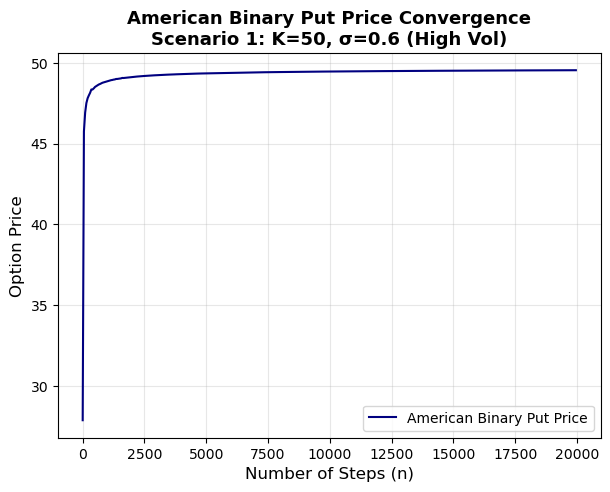

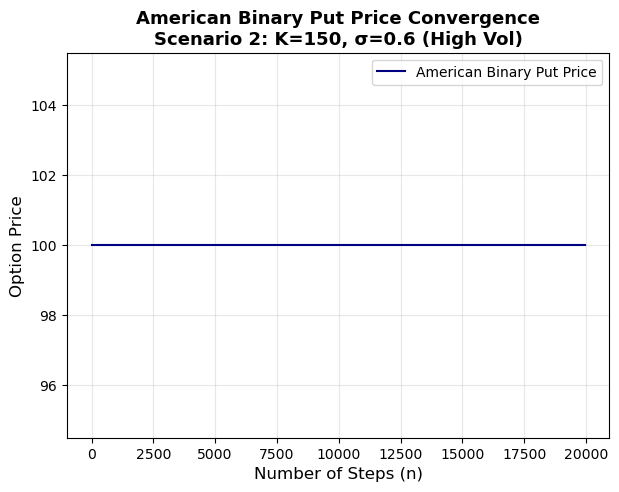

/var/folders/60/rl4yk8jj3453bx7hbt074rbc0000gn/T/ipykernel_16668/2667772401.py:27: RuntimeWarning: invalid value encountered in scalar divide
  d = (erdt - p * u) / (1 - p)


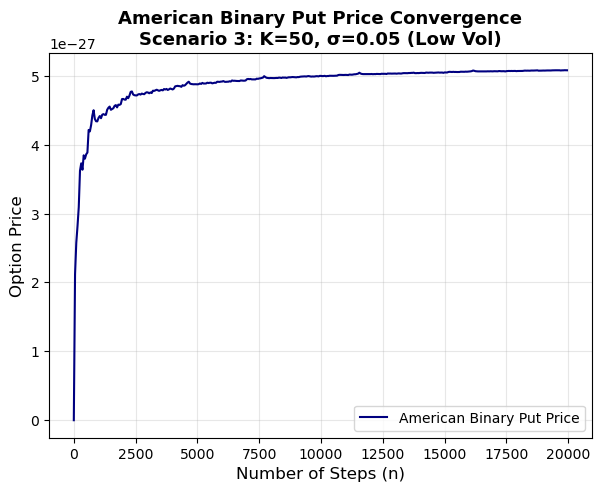

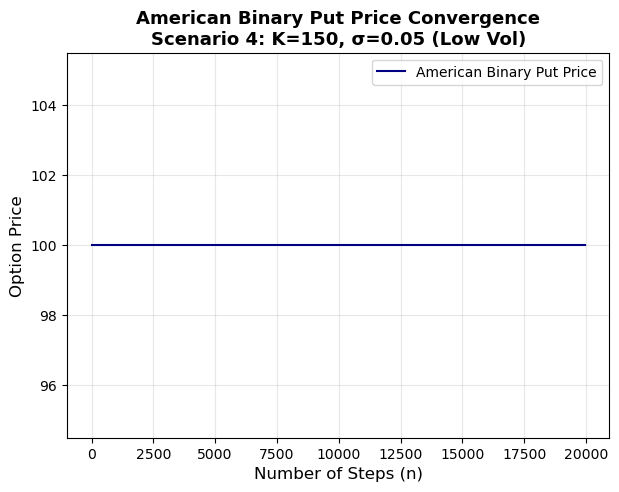

In [33]:
# Usage
# So, K, r, v, T, n, Q
So = 100
r = 0.05
T = 2
Q = 100

# Parameter sets for different scenarios
params_1 = (So, 50, r, 0.6, T, Q)
params_2 = (So, 150, r, 0.6, T, Q)
params_3 = (So, 50, r, 0.05, T, Q)
params_4 = (So, 150, r, 0.05, T, Q)

# Compute values for all scenarios
scenarios = [
    ("Scenario 1: K=50, σ=0.6 (High Vol)", params_1),
    ("Scenario 2: K=150, σ=0.6 (High Vol)", params_2),
    ("Scenario 3: K=50, σ=0.05 (Low Vol)", params_3),
    ("Scenario 4: K=150, σ=0.05 (Low Vol)", params_4)
    ]

for title, params in scenarios:
    plot_AmeConvergence(*params,
                        AmericanPutBinaryTree=AmericanPutBinaryTree_LR,
                        title=title)